# Import and view the data

In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sps

path = 'C:/Users/Utente/Desktop/RecSys_Course_AT_PoliMi-master'
path1 = path + '/interactions_and_impressions.csv'
path2 = path + '/data_ICM_length.csv'
path3 = path + '/data_ICM_type.csv'




URM_interactions = pd.read_csv(path1)
ICM_length = pd.read_csv(path2)
ICM_type = pd.read_csv(path3)



C:\Users\Utente\AppData\Local\Temp\ipykernel_7980\294673183.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  URM_interactions = pd.read_csv(path1)


In [3]:
##IMPRESSION DISCOUNTING

dummy = URM_interactions.copy()
dummy = dummy[dummy["Data"] == 0]
#Impressions is a string of numbers seperated by ",". So I am using str.split to convert them into a list of numbers(ItemIDs)
dummy["Impressions"] = dummy["Impressions"].str.split(",")

#Filling the NaN values with a dummy number that does not exist in ItemID list, these will be dropped later
dummy["Impressions"] = dummy["Impressions"].fillna(99999)

#Explode basicly explodes the list of Impressions, every number in the list is seperated intro independent rows with 
#corresponding UserID ItemID and Data
URM_impressions = dummy.explode(["Impressions"])
URM_impressions["UserID"] = URM_impressions["UserID"].astype(int)
URM_impressions["ItemID"] = URM_impressions["ItemID"].astype(int)
URM_impressions["Impressions"] = URM_impressions["Impressions"].astype(int)
#Dropping the NaN values, we assigned them to dummy numbers otherwise explode does not work 
URM_impressions = URM_impressions.drop(URM_impressions[URM_impressions["Impressions"] == 99999].index)

#Dropping the itemID = Impression, meaning the item user interacted amongst the impression list
URM_impressions = URM_impressions[URM_impressions["ItemID"] != URM_impressions["Impressions"]]

#Now every impression is a seperate itemID that I can assign ratings. So I am selecting those columns and renaming Impressions
#as my new ItemID
URM_impressions = URM_impressions[["UserID","Impressions","Data"]]
URM_impressions.rename(columns = {'Impressions':'ItemID'}, inplace = True)

#I assign every Impression a rating of -1, meaning if the user did not interacted with the item, user did not like it
URM_impressions["Data"] = -1
URM_impressions["UserID"] = URM_impressions["UserID"].astype(int)
URM_impressions["ItemID"] = URM_impressions["ItemID"].astype(int)

URM_impressions

,UserID,ItemID,Data
3,0,20,-1
3,0,22,-1
3,0,23,-1
3,0,24,-1
3,0,25,-1
...,...,...,...
5443853,36018,1675,-1
5443853,36018,2341,-1
5443853,36018,361,-1
5443853,36018,1300,-1


In [137]:
"""interactions_and_impressions.csv : Contains the training set, describing implicit preferences expressed by the users.
-user_id : identifier of the user
-item_id : identifier of the item (TV series)
-impression_list : string containing the items that were present on the screen when the user interacted with the 
 item in column item_id. Not all interactions have a corresponding impressions list.
-data : "0" if the user watched the item, "1" if the user opened the item details page."""
URM_interactions

,UserID,ItemID,Impressions,Data
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,21,NaN,0
2,0,21,NaN,0
3,0,21,"20,21,22,23,24,25,26,27,28,29",0
4,0,21,NaN,1
...,...,...,...,...
5826501,41628,20448,NaN,0
5826502,41628,20896,NaN,1
5826503,41628,21506,NaN,1
5826504,41628,22882,NaN,0


In [4]:
URM_interactions = URM_interactions[["UserID","ItemID","Data"]]
URM_interactions = URM_interactions[URM_interactions["Data"] == 0]

watched = 1;
open_descr = 0;

URM_interactions['Data'][URM_interactions['Data'] == 0] = 3
URM_interactions['Data'][URM_interactions['Data'] == 1] = open_descr # opened - interested
URM_interactions['Data'][URM_interactions['Data'] == 3] = watched # watched
URM_interactions

,UserID,ItemID,Data
1,0,21,1
2,0,21,1
3,0,21,1
37,0,124,1
42,0,808,1
...,...,...,...
5826499,41628,15971,1
5826500,41628,19992,1
5826501,41628,20448,1
5826504,41628,22882,1


<AxesSubplot:>

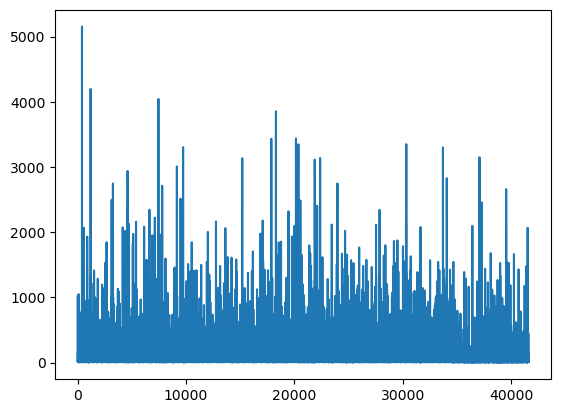

In [6]:
User_Episode = URM_interactions.copy()
User_Episode = User_Episode[["UserID","ItemID","Data"]][URM_interactions['Data'] == 1]
User_Episode["Data"] = User_Episode.groupby(["UserID","ItemID"])["ItemID"].transform("count")
User_Episode.rename(columns = {'Data':'Watched'}, inplace = True)
User_Episode = User_Episode.drop_duplicates(subset = ["UserID" , "ItemID"])
User_Episode = User_Episode.reset_index()

User_Interactions = User_Episode.copy()
User_Interactions["Watched"] = User_Interactions.groupby(["UserID","ItemID"])["Watched"].transform(sum)
User_Interactions = User_Interactions.reset_index()
User_Interactions = User_Interactions.drop_duplicates(subset = ["UserID" , "ItemID"])
User_Interactions = User_Interactions[["UserID","Watched"]]

User_Interactions["TotInteract"] = User_Interactions.groupby(["UserID"])["Watched"].transform(sum)
User_Interactions = User_Interactions.drop(columns = ["Watched"])
User_Interactions = User_Interactions.drop_duplicates(subset = ["UserID"])
User_Interactions = User_Interactions.reset_index()
User_Interactions = User_Interactions.drop(columns = ["index"])
User_Interactions["TotInteract"].plot()


In [21]:
User_Interactions[User_Interactions["TotInteract"]>100]

,UserID,TotInteract
4,4,1025
11,11,200
18,18,172
25,25,244
37,37,122
...,...,...
41562,41562,155
41566,41566,184
41597,41597,447
41620,41620,122


In [141]:
User_Interactions.TotInteract[User_Interactions["TotInteract"] < 5] = 1 
User_Interactions.TotInteract[User_Interactions["TotInteract"].between(10,1000)] = 2
User_Interactions.TotInteract[User_Interactions["TotInteract"] > 1000] = 3

User_Interactions

,UserID,TotInteract
0,0,2
1,1,2
2,2,2
3,3,2
4,4,3
...,...,...
41624,41624,2
41625,41625,2
41626,41626,2
41627,41627,2


In [142]:
ICM_length.data[ICM_length["data"] == 10000] = 1
URM_interactions = pd.concat([URM_interactions,URM_impressions])
ICM_length.rename(columns = {'item_id':'ItemID'}, inplace = True)

User_Episode = User_Episode.merge(ICM_length,on = "ItemID",how = "outer")
User_Episode = User_Episode.dropna(subset = ["UserID","Watched","data"])

User_Episode["Watched"]/=User_Episode["data"]

User_Episode.Watched[User_Episode["Watched"] >= 0.1] = 1
User_Episode.Watched[User_Episode["Watched"] < 0.1] = 0.5

User_Episode = User_Episode[["UserID", "ItemID","Watched"]]
User_Episode = User_Episode.drop_duplicates(subset = ["UserID" , "ItemID"])

User_Episode

C:\Users\Utente\AppData\Local\Temp\ipykernel_19512\734930165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  User_Episode.Watched[User_Episode["Watched"] >= 0.1] = 1
C:\Users\Utente\AppData\Local\Temp\ipykernel_19512\734930165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  User_Episode.Watched[User_Episode["Watched"] < 0.1] = 0.5


,UserID,ItemID,Watched
0,0.0,21,1.0
1,14.0,21,0.5
2,15.0,21,0.5
3,16.0,21,0.5
4,25.0,21,0.5
...,...,...,...
1051812,25890.0,21018,0.5
1051813,26744.0,21018,0.5
1051814,31457.0,21018,0.5
1051815,32594.0,21018,0.5


In [143]:
URM_interactions = URM_interactions.merge(User_Episode,on = ["UserID","ItemID"] ,how = "outer")
URM_interactions["Watched"] = URM_interactions[["Watched"]].fillna(1.0)
URM_interactions["Data"]*=URM_interactions["Watched"]


URM_interactions = URM_interactions.groupby(["UserID","ItemID"])["Data"].mean()
URM_interactions = URM_interactions.reset_index()

URM_interactions

,UserID,ItemID,Data
0,0,20,-1.0
1,0,21,1.0
2,0,22,-1.0
3,0,23,-1.0
4,0,24,-1.0
...,...,...,...
1895256,41628,15971,1.0
1895257,41628,19992,1.0
1895258,41628,20448,1.0
1895259,41628,22882,0.5


In [144]:
ICM_length

,ItemID,feature_id,data
0,0,0,1
1,1,0,1
2,2,0,21
3,3,0,1
4,4,0,1
...,...,...,...
23086,27963,0,1
23087,27964,0,1
23088,27965,0,1
23089,27966,0,1


In [145]:
"""data_ICM_length.csv :
Contains the number of episodes of the items. TV series may have multiple episodes.

-item_id : identifier of the item
-feature_id : identifier of the feature, only one value (0) exists since this ICM only contains the feature "length"
-data : number of episodes. Some values may be 0 due to incomplete data."""
ICM_length.drop(columns = 'feature_id', inplace=True) # same feature is not needed
ICM_length 

,ItemID,data
0,0,1
1,1,1
2,2,21
3,3,1
4,4,1
...,...,...
23086,27963,1
23087,27964,1
23088,27965,1
23089,27966,1


In [146]:
ICM_length["data"] = ICM_length["data"].fillna(0)
ICM_length.loc[ICM_length["data"] > 1 , "data"] = 2
ICM_length

,ItemID,data
0,0,1
1,1,1
2,2,2
3,3,1
4,4,1
...,...,...
23086,27963,1
23087,27964,1
23088,27965,1
23089,27966,1


In [147]:
ICM_length.describe()

,ItemID,data
count,23091.000000,23091.000000
mean,14341.094452,1.429735
std,8236.943085,0.495049
min,0.000000,1.000000
25%,7169.000000,1.000000
50%,14405.000000,1.000000
75%,21646.500000,2.000000
max,27967.000000,2.000000


In [148]:
"""data_ICM_type.csv:
Contains the type of the items. An item can only have one type.
All types are anonymized and described only by a numerical identifier.

-item_id : identifier of the item
-feature_id : identifier of the type
-data : "1" if the item is described by the type"""
ICM_type.drop(columns = 'data', inplace=True) # same feature is not needed
ICM_type

,item_id,feature_id
0,0,1
1,1,3
2,2,4
3,3,1
4,4,3
...,...,...
23086,27963,1
23087,27964,2
23088,27965,1
23089,27966,1


In [97]:
#print ("The number of interactions is {}".format(len(URM_interactions)))
#print ("The number of users is {}".format(max(URM_interactions['UserID'])+1))
#print ("The number of items is {}".format(max(ICM_length['ItemID'])+1))
#print("Sparcity: {}%".format(1-len(int_and_impr)/(n_users*n_items)))

In [149]:
ICM_type.rename(columns = {'item_id':'ItemID'}, inplace = True)
#ICM_length.rename(columns = {'item_id':'ItemID'}, inplace = True)
#ICM_type = ICM_type.merge(ICM_length,on="ItemID",how = "outer")
ICM_type

,ItemID,feature_id
0,0,1
1,1,3
2,2,4
3,3,1
4,4,3
...,...,...
23086,27963,1
23087,27964,2
23088,27965,1
23089,27966,1


In [99]:
#ICM_type.rename(columns = {'data':'epNum'}, inplace = True)

In [150]:
ICM = URM_interactions.merge(ICM_type, on="ItemID", how="outer" )

ICM

,UserID,ItemID,Data,feature_id
0,0.0,20,-1.000000,4.0
1,2.0,20,-0.166667,4.0
2,3.0,20,-1.000000,4.0
3,7.0,20,-1.000000,4.0
4,8.0,20,-1.000000,4.0
...,...,...,...,...
1898717,NaN,27963,NaN,1.0
1898718,NaN,27964,NaN,2.0
1898719,NaN,27965,NaN,1.0
1898720,NaN,27966,NaN,1.0


In [151]:
ICM = ICM.dropna(subset=['UserID'])
ICM["feature_id"] = ICM["feature_id"].fillna(0)
ICM["UserID"] = ICM["UserID"].astype(int)
ICM["ItemID"] = ICM["ItemID"].astype(int)
ICM["feature_id"] = ICM["feature_id"].astype(int)
ICM

C:\Users\Utente\AppData\Local\Temp\ipykernel_19512\3705772614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["feature_id"] = ICM["feature_id"].fillna(0)
C:\Users\Utente\AppData\Local\Temp\ipykernel_19512\3705772614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["UserID"] = ICM["UserID"].astype(int)
C:\Users\Utente\AppData\Local\Temp\ipykernel_19512\3705772614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,UserID,ItemID,Data,feature_id
0,0,20,-1.000000,4
1,2,20,-0.166667,4
2,3,20,-1.000000,4
3,7,20,-1.000000,4
4,8,20,-1.000000,4
...,...,...,...,...
1895256,31757,17054,1.000000,0
1895257,32982,17054,1.000000,0
1895258,35073,17054,1.000000,0
1895259,38013,17054,1.000000,0


In [152]:
mapped_id, original_id = pd.factorize(URM_interactions["UserID"].unique())

print("Unique UserID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_interactions["UserID"], ICM["UserID"],], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique UserID in the URM and ICM are {}".format(len(original_id)))

user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique UserID in the URM are 41629
Unique UserID in the URM and ICM are 41629


In [153]:
mapped_id, original_id = pd.factorize(URM_interactions["ItemID"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))
all_item_indices = pd.concat([URM_interactions["ItemID"], ICM["ItemID"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM are {}".format(len(original_id)))

item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM are 24507


In [154]:
mapped_id, original_id = pd.factorize(URM_interactions["Data"].unique())
data_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [155]:
mapped_id, original_id = pd.factorize(ICM["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [106]:
#mapped_id, original_id = pd.factorize(ICM["epNum"].unique())
#epNum_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [156]:
URM_interactions["ItemID"] = URM_interactions["ItemID"].map(item_original_ID_to_index)
URM_interactions["UserID"] = URM_interactions["UserID"].map(user_original_ID_to_index)
URM_interactions["Data"] = URM_interactions["Data"].map(data_original_ID_to_index)

In [157]:
ICM["ItemID"] = ICM["ItemID"].map(item_original_ID_to_index)
ICM["UserID"] = ICM["UserID"].map(user_original_ID_to_index)
#ICM["epNum"] = ICM["epNum"].map(epNum_original_ID_to_index)
ICM["feature_id"] = ICM["feature_id"].map(feature_original_ID_to_index)


ICM



C:\Users\Utente\AppData\Local\Temp\ipykernel_19512\1065908835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["ItemID"] = ICM["ItemID"].map(item_original_ID_to_index)
C:\Users\Utente\AppData\Local\Temp\ipykernel_19512\1065908835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["UserID"] = ICM["UserID"].map(user_original_ID_to_index)
C:\Users\Utente\AppData\Local\Temp\ipykernel_19512\1065908835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,UserID,ItemID,Data,feature_id
0,0,0,-1.000000,0
1,2,0,-0.166667,0
2,3,0,-1.000000,0
3,7,0,-1.000000,0
4,8,0,-1.000000,0
...,...,...,...,...
1895256,31757,24506,1.000000,2
1895257,32982,24506,1.000000,2
1895258,35073,24506,1.000000,2
1895259,38013,24506,1.000000,2


In [158]:
n_users = len(user_original_ID_to_index)
n_features = len(feature_original_ID_to_index)
n_items = len(item_original_ID_to_index)
#n_episode = len(epNum_original_ID_to_index)


In [159]:
#CREATE URM

URM_all = sps.coo_matrix((np.ones(len(URM_interactions["UserID"].values)), 
                          (URM_interactions["UserID"].values, URM_interactions["ItemID"].values)), 
                         shape = (n_users, n_items))# change the structure here
URM_all

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 1895261 stored elements in COOrdinate format>

In [160]:
from implicit.nearest_neighbours import bm25_weight


# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
URM = bm25_weight(URM_all, K1=100, B=0.8)

# get the transpose since the most of the functions in implicit expect (user, item) sparse matrices instead of (item, user)
URM_all = URM.tocsr()

In [161]:
#CREATE ICM
ICM_all = sps.csr_matrix((np.ones(len(ICM["ItemID"].values)), 
                          (ICM["ItemID"].values, ICM["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all

<24507x6 sparse matrix of type '<class 'numpy.float64'>'
	with 24507 stored elements in Compressed Sparse Row format>

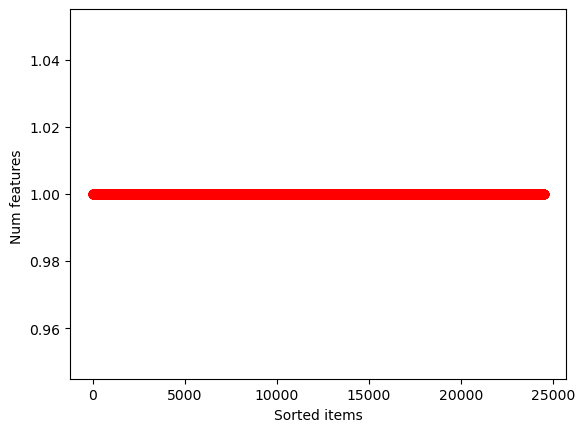

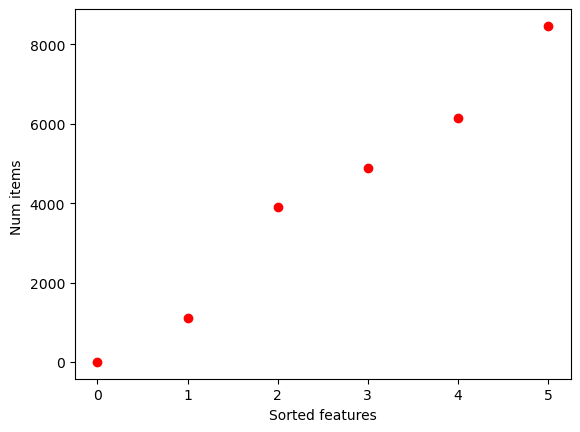

In [162]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

In [163]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.85)


In [164]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


EvaluatorHoldout: Ignoring 2397 ( 5.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1638 ( 3.9%) Users that have less than 1 test interactions


In [ ]:
#results_df, _ = evaluator_test.evaluateRecommender(itemKNNCF)
#results_df

In [166]:
from skopt.space import Real, Integer, Categorical

hyperparameters_range_dictionary = {
    "topK": Integer(5, 1000),
    "shrink": Integer(0, 1000),
    "similarity": Categorical(["cosine","dice","jaccard","pearson"]),
    "normalize": Categorical([True, False]),
}

from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt

recommender_class = ItemKNNCFRecommender

hyperparameterSearch = SearchBayesianSkopt(recommender_class,
                                         evaluator_validation=evaluator_validation,
                                         evaluator_test=evaluator_test)

from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
  
recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train],     # For a CBF model simply put [URM_train, ICM_train]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train_validation],     # For a CBF model simply put [URM_train_validation, ICM_train]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

import os

output_folder_path = "result_experiments/"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    
n_cases = 10  # using 10 as an example
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP"   
cutoff_to_optimize = 10

hyperparameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       hyperparameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = n_random_starts,
                       save_model = "last",
                       output_folder_path = output_folder_path, # Where to save the results
                       output_file_name_root = recommender_class.RECOMMENDER_NAME, # How to call the files
                       metric_to_optimize = metric_to_optimize,
                       cutoff_to_optimize = cutoff_to_optimize,
                      )


Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 312, 'shrink': 446, 'similarity': 'jaccard', 'normalize': False}
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 902.95 column/sec. Elapsed time 27.14 sec
EvaluatorHoldout: Processed 39232 (100.0%) in 27.43 sec. Users per second: 1431
SearchBayesianSkopt: New best config found. Config 0: {'topK': 312, 'shrink': 446, 'similarity': 'jaccard', 'normalize': False} - results: PRECISION: 0.1349230, PRECISION_RECALL_MIN_DEN: 0.2337294, RECALL: 0.2180135, MAP: 0.0795019, MAP_MIN_DEN: 0.1338252, MRR: 0.3631119, NDCG: 0.0640209, F1: 0.1666874, HIT_RATE: 0.5990263, ARHR_ALL_HITS: 0.5300693, NOVELTY: 0.0040140, AVERAGE_POPULARITY: 0.2579731, DIVERSITY_MEAN_INTER_LIST: 0.9451059, DIVERSITY_HERFINDAHL: 0.9945082, COVERAGE_ITEM: 0.2407883, COVERAGE_ITEM_HIT: 0.0695312, ITEMS_

SearchBayesianSkopt: Config evaluated with evaluator_test. Config: {'topK': 105, 'shrink': 179, 'similarity': 'jaccard', 'normalize': False} - results:
CUTOFF: 10 - PRECISION: 0.1629142, PRECISION_RECALL_MIN_DEN: 0.2490548, RECALL: 0.2231091, MAP: 0.1019274, MAP_MIN_DEN: 0.1515995, MRR: 0.4058602, NDCG: 0.0695782, F1: 0.1883183, HIT_RATE: 0.6313170, ARHR_ALL_HITS: 0.6308910, NOVELTY: 0.0041762, AVERAGE_POPULARITY: 0.2232892, DIVERSITY_MEAN_INTER_LIST: 0.9593202, DIVERSITY_HERFINDAHL: 0.9959296, COVERAGE_ITEM: 0.2797160, COVERAGE_ITEM_HIT: 0.0845473, ITEMS_IN_GT: 0.9594402, COVERAGE_USER: 0.9606524, COVERAGE_USER_HIT: 0.6064763, USERS_IN_GT: 0.9606524, DIVERSITY_GINI: 0.0286154, SHANNON_ENTROPY: 9.3743674, RATIO_DIVERSITY_HERFINDAHL: 0.9968106, RATIO_DIVERSITY_GINI: 0.1027464, RATIO_SHANNON_ENTROPY: 0.7627257, RATIO_AVERAGE_POPULARITY: 2.0360764, RATIO_NOVELTY: 0.2531544, 


Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 57.9880
Function value obtained: -

EvaluatorHoldout: Processed 39232 (100.0%) in 31.98 sec. Users per second: 1227
SearchBayesianSkopt: Config 9 is suboptimal. Config: {'topK': 446, 'shrink': 405, 'similarity': 'cosine', 'normalize': False} - results: PRECISION: 0.1309849, PRECISION_RECALL_MIN_DEN: 0.2298763, RECALL: 0.2152497, MAP: 0.0764098, MAP_MIN_DEN: 0.1304185, MRR: 0.3586232, NDCG: 0.0549137, F1: 0.1628633, HIT_RATE: 0.5982361, ARHR_ALL_HITS: 0.5168597, NOVELTY: 0.0038902, AVERAGE_POPULARITY: 0.3180146, DIVERSITY_MEAN_INTER_LIST: 0.9161114, DIVERSITY_HERFINDAHL: 0.9916088, COVERAGE_ITEM: 0.4277553, COVERAGE_ITEM_HIT: 0.0612070, ITEMS_IN_GT: 0.9352430, COVERAGE_USER: 0.9424199, COVERAGE_USER_HIT: 0.5637897, USERS_IN_GT: 0.9424199, DIVERSITY_GINI: 0.0253089, SHANNON_ENTROPY: 8.3819885, RATIO_DIVERSITY_HERFINDAHL: 0.9924859, RATIO_DIVERSITY_GINI: 0.0908740, RATIO_SHANNON_ENTROPY: 0.6819829, RATIO_AVERAGE_POPULARITY: 2.8998366, RATIO_NOVELTY: 0.2358158, 

Iteration No: 10 ended. Search finished for the next optimal p

In [167]:
from Recommenders.DataIO import DataIO

data_loader = DataIO(folder_path = output_folder_path)
search_metadata = data_loader.load_data(recommender_class.RECOMMENDER_NAME + "_metadata.zip")

search_metadata.keys()

dict_keys(['algorithm_name_recommender', 'algorithm_name_search', 'cutoff_to_optimize', 'exception_list', 'hyperparameters_best', 'hyperparameters_best_index', 'hyperparameters_df', 'metric_to_optimize', 'result_on_earlystopping_df', 'result_on_last', 'result_on_test_best', 'result_on_test_df', 'result_on_validation_best', 'result_on_validation_df', 'time_df', 'time_on_last_df', 'time_on_test_avg', 'time_on_test_total', 'time_on_train_avg', 'time_on_train_total', 'time_on_validation_avg', 'time_on_validation_total'])

In [168]:
hyperparameters_df = search_metadata["hyperparameters_df"]
hyperparameters_df

,topK,shrink,similarity,normalize
0,312,446,jaccard,False
1,549,404,dice,False
2,346,517,jaccard,False
3,213,350,pearson,False
4,105,179,jaccard,False
5,912,9,pearson,True
6,5,0,jaccard,True
7,249,0,jaccard,False
8,517,999,dice,True
9,446,405,cosine,False


In [169]:
result_on_validation_df = search_metadata["result_on_validation_df"]
result_on_validation_df

,,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
,cutoff,,,,,,,,,,,,,,,,,,,,,
0,10,0.134923,0.233729,0.218013,0.079502,0.133825,0.363112,0.064021,0.166687,0.599026,0.530069,...,0.94242,0.564534,0.94242,0.020316,8.843767,0.995388,0.072947,0.719554,2.352344,0.243325
1,10,0.134984,0.234897,0.219433,0.079442,0.13422,0.364285,0.06483,0.167148,0.603003,0.530959,...,0.94242,0.568282,0.94242,0.020581,8.895277,0.995633,0.073897,0.723745,2.298948,0.244212
2,10,0.133633,0.232124,0.216703,0.078784,0.1328,0.361878,0.062534,0.16532,0.596605,0.526895,...,0.94242,0.562252,0.94242,0.019318,8.761198,0.995124,0.069362,0.712836,2.406068,0.241893
3,10,0.131423,0.231397,0.216812,0.075603,0.129645,0.358523,0.056239,0.163649,0.605806,0.514324,...,0.94242,0.570924,0.94242,0.026699,8.561778,0.99312,0.095865,0.696611,2.771724,0.238768
4,10,0.140087,0.240782,0.223859,0.082452,0.137846,0.367648,0.073328,0.172332,0.607336,0.54245,...,0.94242,0.572365,0.94242,0.027961,9.34903,0.996767,0.100397,0.760664,2.045756,0.252762
5,10,0.136259,0.233936,0.21837,0.078965,0.132275,0.358217,0.070995,0.167808,0.599332,0.525175,...,0.94242,0.564823,0.94242,0.136556,10.562207,0.997106,0.490319,0.859372,1.930178,0.282462
6,10,0.130763,0.220617,0.204101,0.073309,0.12052,0.3338,0.08686,0.159401,0.582611,0.48737,...,0.94242,0.549064,0.94242,0.100174,11.234614,0.999675,0.359686,0.914081,1.116627,0.293989
7,10,0.141255,0.242037,0.224938,0.082611,0.137723,0.3663,0.08124,0.173535,0.609477,0.542044,...,0.94242,0.574383,0.94242,0.055948,10.07479,0.997797,0.200888,0.819714,1.755598,0.26887
8,10,0.128487,0.224484,0.209988,0.075621,0.128326,0.356055,0.056337,0.159425,0.589621,0.512101,...,0.94242,0.55567,0.94242,0.015728,8.428779,0.993943,0.056473,0.68579,2.624959,0.236349


In [170]:
result_best_on_test = search_metadata["result_on_last"]
result_best_on_test

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.187765,0.278494,0.2452,0.145509,0.207294,0.499519,0.095867,0.212673,0.643345,0.82538,...,0.960652,0.618031,0.960652,0.045765,9.931916,0.997739,0.163379,0.80788,1.740723,0.226464


In [171]:
best_hyperparameters = search_metadata["hyperparameters_best"]
best_hyperparameters

{'topK': 249, 'shrink': 0, 'similarity': 'jaccard', 'normalize': False}

In [172]:
{'topK': 249, 'shrink': 0, 'similarity': 'jaccard', 'normalize': False}
best_hyperparams_ItemKNNCF = best_hyperparameters

from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_hyperparams_ItemKNNCF)

results_df, _ = evaluator_test.evaluateRecommender(itemKNNCF)
results_df

ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 949.79 column/sec. Elapsed time 25.80 sec
EvaluatorHoldout: Processed 39991 (100.0%) in 23.20 sec. Users per second: 1724


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.163699,0.249025,0.223022,0.10196,0.151225,0.404059,0.077355,0.188811,0.630192,0.62958,...,0.960652,0.605395,0.960652,0.058281,10.116755,0.997848,0.209265,0.823128,1.741585,0.26969


In [399]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        item_popularity = np.ediff1d(URM_train.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at):
    
        recommended_items = self.popular_items[0:at]
        recommended_items = recommended_items.tolist()

        return recommended_items
    


In [173]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
#from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
#best_hyperparameters = {'topK': 816, 'shrink': 0, 'similarity': 'cosine', 'normalize': True}
#best_hyperparams_ItemKNNCF = best_hyperparameters
#best_shrink = 0
#urm_train_validation = URM_train + URM_validation
ItemKNNCF = ItemKNNCFRecommender(URM_train_validation)
ItemKNNCF.fit(**best_hyperparams_ItemKNNCF)
#UserKNNCF = UserKNNCFRecommender(URM_all)
#UserKNNCF.fit()
#TopPop = TopPopRecommender()
#TopPop.fit(URM_all)

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 821.07 column/sec. Elapsed time 29.85 sec


In [426]:
def ChooseRecommender(UserID: int ,user_prof: dict):
    global recom
    if user_prof[UserID] == 1:
        recom = TopPop
    if user_prof[UserID] == 2:
        recom = ItemKNNCF
    if user_prof[UserID] == 3:
        recom = UserKNNCF
    return recom

In [69]:
path4 = path + '/data_target_users_test.csv'
users_to_recommend = pd.read_csv(path4)
users_to_recommend

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
41111,41624
41112,41625
41113,41626
41114,41627


In [174]:

import scipy.sparse as sp
def prepare_submission(ratings: pd.DataFrame, users_to_recommend: np.array, urm_train: sp.csr_matrix, recommender: object):
    #users_ids_and_mappings = user_original_ID_to_index.to_frame()
    #users_ids_and_mappings = users_ids_and_mappings.drop_duplicates()
    #users_ids_and_mappings = users_ids_and_mappings.reset_index(level=0)
    #users_ids_and_mappings.columns = ["mapped_user_id","user_id"]
    #users_ids_and_mappings = users_ids_and_mappings[users_ids_and_mappings.user_id.isin(users_to_recommend["user_id"])][["mapped_user_id", "user_id"]].drop_duplicates()
    
    #items_ids_and_mappings = item_original_ID_to_index.to_frame()
    #items_ids_and_mappings = items_ids_and_mappings.drop_duplicates()
    #items_ids_and_mappings = items_ids_and_mappings.reset_index(level=0)
    #items_ids_and_mappings.columns = ["mapped_item_id","item_id"]
    
    inv_map = dict(item_original_ID_to_index)
    mapping_to_item_id = {v: k for k, v in inv_map.items()}
    
    recommendation_length = 10
    submission = []
    for idx, row in users_to_recommend.iterrows():
        user_id = row.user_id
        mapped_user_id = user_original_ID_to_index[user_id]
       #recommender = ChooseRecommender(int(mapped_user_id),user_prof)
        recommendations = recommender.recommend(int(mapped_user_id),10,remove_seen_flag = True)
        print(user_id ,",",recommendations)
        rec_list = [mapping_to_item_id[ItemID] for ItemID in recommendations]
        rec_list = [int(x) for x in rec_list]
        submission.append((user_id, rec_list))
        
    return submission


In [175]:
submission = prepare_submission(URM_all, users_to_recommend, URM_train_validation,itemKNNCF)


0 , [0, 8, 14, 6, 133, 41, 320, 489, 107, 106]
1 , [6878, 31, 3368, 2240, 4409, 4426, 2308, 2317, 4408, 4423]
2 , [1125, 4113, 1126, 56, 119, 51, 9600, 61, 1127, 1114]
3 , [145, 126, 146, 884, 113, 19371, 149, 140, 148, 150]
4 , [777, 790, 788, 791, 782, 783, 779, 781, 774, 615]
5 , [239, 108, 320, 164, 111, 325, 165, 330, 163, 319]
6 , [11248, 6054, 19001, 4, 5, 1692, 10, 0, 14147, 2]
7 , [8, 3, 14, 13, 266, 264, 9, 268, 900, 3076]
8 , [305, 306, 302, 8, 4, 2945, 14, 13, 9, 15]
9 , [10, 1, 2, 320, 9, 106, 330, 133, 108, 15]
10 , [370, 373, 363, 382, 371, 383, 365, 369, 372, 1568]
11 , [3, 430, 5, 2931, 8, 4, 9, 3309, 428, 7]
12 , [491, 1496, 471, 792, 472, 478, 125, 810, 490, 649]
13 , [874, 9165, 12588, 9166, 9635, 14765, 6185, 4498, 1035, 10655]
14 , [108, 8, 106, 13, 9, 164, 7, 165, 15, 6]
15 , [4, 10, 5, 9, 7, 13, 15, 489, 334, 12]
16 , [2945, 309, 893, 587, 5554, 2720, 2941, 10193, 14565, 5553]
17 , [3658, 3380, 4932, 2495, 172, 2496, 3661, 3656, 2983, 4933]
18 , [790, 779, 777, 

396 , [10, 13, 7, 14, 12, 11, 107, 133, 320, 108]
397 , [3099, 3101, 385, 1060, 2550, 384, 3089, 389, 387, 376]
398 , [735, 732, 0, 1, 107, 320, 12, 14, 164, 7]
399 , [800, 801, 650, 892, 54, 475, 982, 118, 44, 327]
400 , [2205, 373, 385, 389, 1006, 1570, 3038, 2246, 2243, 367]
401 , [365, 372, 375, 1064, 1062, 2549, 386, 2550, 376, 363]
402 , [391, 2269, 2362, 1064, 386, 1065, 390, 3273, 2250, 387]
403 , [67, 46, 861, 56, 55, 2753, 51, 463, 7469, 53]
404 , [11456, 461, 64, 460, 2385, 8973, 4571, 4062, 464, 9839]
405 , [0, 11, 1, 8, 107, 10, 4, 2, 133, 320]
406 , [12, 164, 242, 111, 165, 163, 110, 692, 166, 170]
407 , [615, 784, 775, 205, 206, 399, 812, 786, 796, 1241]
408 , [3167, 4779, 6826, 4781, 6936, 4780, 6935, 11160, 4782, 279]
409 , [4335, 4334, 4337, 4325, 55, 3631, 4328, 4327, 3511, 4330]
410 , [2588, 3104, 3099, 3105, 2549, 384, 3101, 1568, 3091, 3094]
411 , [367, 376, 389, 388, 370, 362, 1061, 382, 386, 1067]
412 , [106, 242, 165, 325, 111, 163, 330, 3, 5, 558]
413 , [14512

783 , [4255, 2243, 3019, 2214, 5577, 1570, 2254, 2260, 3940, 7837]
784 , [10, 1, 14, 9, 13, 11, 15, 41, 133, 489]
785 , [10243, 3399, 9206, 3252, 3253, 859, 1253, 3250, 9695, 5019]
786 , [289, 777, 774, 790, 788, 775, 779, 781, 791, 783]
787 , [0, 8, 10, 1, 2, 9, 13, 7, 133, 15]
788 , [452, 20555, 10678, 13759, 18863, 6126, 11318, 21095, 3119, 10140]
789 , [2124, 7444, 3077, 2670, 3027, 7443, 5635, 3029, 2123, 463]
790 , [107, 108, 12, 109, 239, 330, 110, 1417, 332, 1418]
791 , [10, 4, 14, 13, 9, 133, 11, 106, 6, 320]
792 , [8, 5, 14, 2166, 9, 2167, 6, 41, 13, 7]
793 , [14, 13, 6, 11, 133, 489, 12, 566, 269, 334]
794 , [5826, 5821, 800, 5818, 5824, 5820, 5104, 650, 490, 492]
795 , [107, 106, 108, 111, 239, 166, 109, 320, 110, 165]
796 , [1210, 1573, 376, 2225, 2508, 3942, 4252, 162, 3940, 4254]
797 , [17067, 17780, 4677, 22585, 4662, 4673, 5393, 2540, 4645, 4660]
798 , [3492, 8, 0, 4, 3, 5, 626, 625, 1452, 1449]
799 , [10, 5, 3, 14, 1, 111, 330, 166, 7, 332]
800 , [107, 108, 239, 320, 

1161 , [1418, 1281, 126, 1425, 4857, 321, 2162, 470, 484, 469]
1162 , [333, 167, 106, 331, 107, 325, 320, 165, 108, 239]
1163 , [434, 2710, 2263, 2266, 1141, 2264, 905, 2722, 309, 894]
1164 , [492, 649, 798, 802, 801, 475, 805, 800, 462, 984]
1165 , [736, 727, 107, 166, 109, 320, 108, 3, 110, 330]
1166 , [4113, 4112, 5361, 67, 20669, 65, 50, 23332, 4111, 23929]
1168 , [320, 1, 239, 13, 330, 7, 164, 15, 325, 650]
1169 , [2882, 8, 3, 2, 4, 1, 14, 7, 13, 2755]
1170 , [4, 8, 0, 12, 133, 107, 320, 108, 167, 109]
1171 , [3394, 3395, 1063, 3393, 12, 1062, 107, 320, 239, 330]
1172 , [4421, 4419, 4418, 1694, 4416, 2281, 6608, 4430, 3034, 5586]
1173 , [108, 109, 239, 320, 330, 332, 110, 333, 28, 325]
1174 , [3189, 3193, 4783, 3186, 3665, 4774, 3315, 3076, 11562, 4781]
1175 , [108, 107, 2, 1, 5, 4, 320, 239, 12, 8]
1176 , [3396, 371, 365, 384, 385, 390, 3368, 372, 387, 1568]
1177 , [111, 107, 106, 12, 166, 109, 108, 4409, 239, 28]
1178 , [1062, 385, 369, 372, 389, 373, 1568, 2360, 375, 2549]
1179

1540 , [4424, 4423, 4426, 4431, 4409, 4429, 2317, 4422, 3368, 4430]
1541 , [239, 320, 792, 495, 475, 0, 3, 1, 4, 5]
1542 , [6446, 4636, 8959, 4639, 4637, 4638, 8957, 8960, 4728, 8950]
1543 , [166, 332, 134, 333, 110, 331, 108, 28, 330, 107]
1544 , [54, 3138, 112, 62, 56, 887, 4, 10, 45, 50]
1545 , [462, 649, 3151, 650, 495, 983, 3592, 3583, 3283, 94]
1546 , [2312, 3046, 3041, 4430, 1573, 2250, 1569, 4429, 4408, 161]
1547 , [777, 790, 791, 782, 781, 785, 775, 205, 207, 789]
1548 , [107, 108, 239, 320, 111, 242, 165, 166, 163, 28]
1549 , [166, 5824, 28, 5818, 167, 5823, 331, 106, 5826, 168]
1550 , [810, 502, 1602, 1498, 1092, 0, 15, 2, 10, 467]
1551 , [649, 892, 62, 502, 495, 799, 324, 113, 798, 119]
1552 , [3076, 275, 2718, 277, 4780, 900, 2711, 898, 4779, 7279]
1553 , [3964, 7350, 2280, 952, 1063, 365, 7348, 1061, 6756, 2359]
1554 , [8, 14, 7, 107, 106, 111, 6, 320, 109, 11]
1555 , [2264, 2721, 2263, 13562, 190, 2722, 5141, 24002, 20459, 7009]
1556 , [0, 12, 106, 165, 111, 41, 163, 110

1924 , [106, 111, 107, 320, 28, 108, 333, 166, 109, 164]
1925 , [1449, 4081, 626, 4080, 624, 1456, 5692, 1445, 627, 4540]
1926 , [2573, 2574, 1574, 2572, 2570, 1419, 1603, 2349, 2567, 1415]
1927 , [2449, 2447, 1489, 2860, 1488, 2454, 2452, 5516, 2453, 2450]
1928 , [4933, 172, 14, 3661, 13, 0, 3, 9, 15, 1]
1929 , [109, 320, 108, 325, 165, 330, 110, 166, 28, 558]
1930 , [3052, 3042, 2313, 2245, 0, 2312, 2, 2206, 4, 492]
1931 , [777, 788, 783, 781, 614, 776, 778, 797, 795, 921]
1932 , [2245, 3041, 2256, 3556, 3743, 3053, 6752, 1572, 3055, 375]
1933 , [1581, 3151, 3152, 92, 97, 3592, 235, 3591, 3575, 3583]
1934 , [3921, 2727, 3916, 5681, 9238, 711, 2725, 3, 9239, 5]
1935 , [5015, 3631, 9206, 4324, 3511, 2705, 3654, 492, 650, 4326]
1936 , [799, 495, 475, 491, 492, 490, 327, 982, 112, 647]
1937 , [653, 129, 4156, 649, 655, 980, 979, 114, 157, 116]
1938 , [509, 62, 112, 166, 119, 1117, 3394, 3393, 3398, 106]
1939 , [630, 8049, 4792, 4793, 3077, 619, 6934, 3029, 3028, 3027]
1940 , [5261, 6224,

2301 , [3107, 9403, 3097, 3106, 3098, 2, 4, 0, 8, 3093]
2302 , [728, 731, 484, 727, 125, 117, 106, 490, 495, 649]
2303 , [9845, 7296, 7637, 3468, 8037, 10051, 10048, 10049, 15024, 10057]
2304 , [15580, 14999, 4535, 14525, 3331, 454, 9845, 8632, 3404, 15523]
2305 , [1789, 1956, 1823, 1795, 1876, 1954, 1824, 1797, 1890, 1866]
2306 , [1317, 109, 108, 170, 107, 164, 1391, 106, 558, 320]
2307 , [4178, 8257, 4177, 8256, 1341, 788, 15395, 777, 3438, 790]
2308 , [1492, 1495, 8818, 3149, 1692, 330, 110, 2526, 111, 28]
2309 , [431, 428, 4209, 2935, 2936, 2933, 2934, 2918, 2910, 8124]
2310 , [3964, 2258, 3945, 7345, 3946, 7350, 851, 3965, 850, 860]
2311 , [2524, 6856, 6861, 1014, 4917, 76, 1185, 3488, 3131, 6155]
2312 , [332, 28, 110, 330, 106, 167, 107, 331, 168, 325]
2313 , [501, 1, 14, 12, 7, 111, 320, 1496, 108, 110]
2314 , [1, 3, 7, 9, 6, 11, 15, 133, 3067, 12]
2315 , [4113, 66, 60, 861, 61, 3138, 58, 1400, 50, 1033]
2316 , [264, 266, 885, 263, 1062, 391, 3885, 2359, 386, 1061]
2317 , [14583

2633 , [777, 782, 791, 776, 785, 787, 784, 797, 207, 921]
2634 , [508, 504, 505, 501, 107, 4, 3, 108, 0, 239]
2635 , [166, 106, 320, 325, 3, 242, 5, 10, 692, 0]
2636 , [801, 802, 798, 490, 492, 649, 44, 475, 281, 982]
2637 , [892, 118, 310, 805, 800, 798, 982, 499, 45, 119]
2638 , [330, 12, 320, 15, 109, 5, 3, 107, 13, 239]
2639 , [490, 649, 801, 798, 650, 492, 805, 118, 892, 166]
2640 , [505, 1098, 1092, 502, 324, 1602, 2567, 2570, 1500, 1031]
2641 , [7510, 9325, 792, 1116, 509, 42, 1117, 492, 9323, 119]
2642 , [492, 649, 509, 112, 8, 892, 650, 113, 3, 10]
2643 , [1576, 2577, 1574, 2574, 2811, 2576, 2349, 5366, 1419, 3486]
2644 , [10, 0, 3, 1, 6, 13, 7, 14, 9, 133]
2645 , [2216, 2205, 162, 2217, 2207, 2215, 2210, 2161, 1573, 1166]
2646 , [384, 387, 375, 2549, 1061, 2359, 2181, 371, 363, 376]
2647 , [794, 1415, 468, 1711, 810, 1098, 508, 1496, 501, 1092]
2648 , [387, 2549, 2550, 1061, 375, 2359, 391, 1064, 376, 1060]
2649 , [12, 242, 111, 163, 110, 692, 166, 170, 319, 558]
2650 , [21, 

3015 , [14, 4, 10, 0, 5, 3, 7, 6, 9, 13]
3016 , [7384, 6750, 7389, 5828, 987, 7387, 6749, 7395, 6753, 6752]
3017 , [3913, 1976, 2727, 3334, 2723, 3917, 3924, 711, 2507, 3914]
3018 , [3398, 3038, 2312, 3053, 3047, 2362, 3397, 2804, 365, 1210]
3019 , [501, 3, 0, 508, 8, 1, 4, 10, 2, 1496]
3020 , [4178, 3438, 2998, 1113, 2833, 645, 3592, 3591, 3281, 92]
3021 , [3394, 3392, 381, 390, 366, 375, 376, 372, 2804, 4414]
3022 , [1245, 1249, 239, 12, 242, 165, 111, 325, 330, 692]
3023 , [2359, 391, 1061, 1063, 412, 390, 2804, 386, 2269, 2360]
3024 , [6844, 11562, 3204, 4784, 11564, 11563, 3205, 792, 3185, 3182]
3025 , [4331, 1063, 391, 4326, 1062, 4325, 3511, 386, 109, 412]
3026 , [2378, 3702, 601, 4456, 208, 9, 1168, 411, 3991, 2983]
3027 , [1970, 2911, 3654, 12412, 2905, 12413, 12411, 3655, 1590, 2915]
3028 , [3047, 3046, 3045, 3043, 2287, 3048, 3049, 3044, 2250, 3393]
3029 , [14465, 5242, 14948, 13430, 10465, 17933, 20894, 16446, 19276, 23731]
3030 , [137, 2162, 125, 124, 9204, 126, 469, 128, 

3354 , [365, 2310, 369, 372, 384, 387, 1568, 3197, 389, 362]
3355 , [777, 782, 615, 776, 207, 924, 222, 431, 786, 3309]
3356 , [14240, 4293, 890, 16428, 1687, 984, 19899, 0, 8, 6870]
3357 , [777, 791, 782, 783, 781, 613, 787, 797, 206, 399]
3358 , [6709, 9242, 9238, 7643, 23062, 3923, 5681, 2725, 10975, 15980]
3359 , [1142, 897, 1141, 2710, 7797, 3666, 896, 4933, 1365, 905]
3360 , [242, 165, 111, 163, 325, 330, 692, 170, 3, 1]
3361 , [2167, 2168, 9, 2379, 0, 107, 10, 8, 5, 239]
3362 , [3486, 3472, 3222, 161, 103, 2702, 2240, 2091, 3131, 162]
3363 , [1602, 320, 109, 466, 15, 1496, 107, 3, 13, 106]
3364 , [1126, 4637, 8960, 8204, 4100, 8958, 46, 47, 16209, 1120]
3365 , [3, 8, 5, 466, 4, 13, 15, 508, 810, 320]
3366 , [505, 504, 501, 1496, 503, 466, 810, 324, 2091, 4422]
3367 , [0, 1, 8, 10, 4, 14, 2, 13, 15, 11]
3368 , [781, 613, 774, 614, 776, 205, 797, 924, 795, 789]
3369 , [1097, 15, 5, 14, 10, 0, 8, 2, 4, 320]
3370 , [8955, 8973, 8974, 4061, 6447, 8951, 4064, 8976, 7719, 4065]
3371 , 

3745 , [408, 7288, 16, 11, 15, 14, 208, 4456, 0, 405]
3746 , [4727, 7444, 23855, 7443, 23598, 21564, 23459, 3714, 2124, 11032]
3747 , [3, 14, 13, 2, 5, 15, 9, 10, 8, 4]
3748 , [613, 774, 781, 614, 785, 784, 207, 797, 222, 795]
3749 , [726, 18, 5693, 490, 327, 492, 118, 45, 650, 649]
3750 , [365, 373, 387, 375, 2359, 1063, 367, 2171, 376, 368]
3751 , [325, 165, 330, 163, 166, 110, 692, 28, 558, 170]
3752 , [788, 782, 779, 613, 774, 781, 615, 614, 784, 205]
3753 , [492, 118, 892, 327, 982, 732, 802, 801, 18, 646]
3754 , [111, 166, 110, 332, 107, 108, 320, 109, 239, 164]
3755 , [2588, 3109, 3103, 3094, 3089, 6759, 2547, 2466, 5164, 385]
3756 , [5409, 1363, 4398, 6384, 6387, 2168, 2382, 2165, 2167, 13839]
3757 , [2111, 2104, 2103, 2109, 2110, 2114, 2107, 2108, 2113, 2112]
3758 , [10, 3, 8, 5, 4, 7, 13, 135, 6, 11]
3759 , [4837, 0, 10, 3, 5, 1365, 13, 9, 7, 1090]
3760 , [1711, 1092, 794, 505, 793, 324, 504, 503, 1602, 1031]
3761 , [790, 788, 774, 787, 207, 789, 812, 786, 925, 796]
3762 , [8

4065 , [792, 490, 491, 982, 649, 327, 650, 463, 984, 0]
4066 , [2, 9, 0, 4, 1090, 107, 14, 13, 15, 6]
4067 , [508, 467, 466, 504, 503, 1496, 1498, 793, 324, 1602]
4068 , [6159, 5724, 4922, 4920, 7841, 4375, 13086, 5120, 87, 3131]
4069 , [735, 728, 731, 734, 8, 0, 3, 5, 6, 13]
4070 , [137, 892, 650, 42, 891, 281, 494, 649, 2162, 475]
4071 , [10, 8, 1, 13, 9, 11, 566, 269, 41, 134]
4072 , [508, 504, 503, 1498, 502, 324, 1602, 1092, 1098, 467]
4073 , [3019, 5579, 3949, 2254, 5577, 3044, 5587, 1570, 3743, 2260]
4074 , [1581, 615, 779, 790, 3151, 777, 614, 782, 775, 207]
4075 , [3222, 83, 87, 4917, 3486, 3472, 12292, 76, 607, 12095]
4076 , [2879, 2755, 4688, 2883, 4696, 4650, 15738, 4652, 2882, 4678]
4077 , [8, 4, 5, 14, 7, 9, 13, 6, 133, 15]
4078 , [106, 12, 14, 165, 1, 164, 28, 240, 111, 15]
4079 , [0, 10, 3, 8, 5, 13, 6, 7, 41, 133]
4080 , [8, 10, 9, 13, 14, 7, 391, 3486, 6, 1062]
4081 , [15703, 20435, 4274, 6754, 2079, 6755, 7387, 5162, 2237, 18753]
4082 , [7547, 46, 119, 44, 66, 260, 4

4424 , [333, 12, 110, 3, 108, 5, 0, 320, 8, 109]
4425 , [712, 176, 2, 4814, 3, 1, 2429, 4, 8, 5]
4426 , [369, 4408, 371, 4409, 366, 2269, 4429, 1064, 4411, 4427]
4427 , [320, 239, 3, 111, 330, 5, 4, 165, 0, 110]
4428 , [5235, 5234, 5233, 471, 5237, 484, 149, 1978, 479, 3442]
4429 , [109, 106, 111, 166, 164, 330, 332, 28, 325, 242]
4430 , [2252, 5593, 5590, 5587, 1571, 5579, 4421, 3940, 4407, 2293]
4431 , [4977, 320, 106, 7159, 242, 7379, 3761, 165, 111, 558]
4432 , [788, 774, 615, 614, 785, 775, 797, 921, 795, 789]
4433 , [801, 802, 499, 475, 982, 799, 792, 327, 118, 495]
4434 , [10, 330, 320, 110, 28, 4, 8, 107, 163, 108]
4435 , [1006, 5927, 6224, 2205, 6222, 2289, 6225, 3955, 3956, 3558]
4436 , [777, 779, 781, 613, 614, 795, 786, 1250, 780, 1251]
4437 , [2588, 7387, 6751, 2237, 6753, 6749, 3105, 7384, 3095, 369]
4438 , [109, 0, 8, 41, 5, 13, 2379, 239, 164, 15]
4439 , [475, 490, 1115, 802, 42, 801, 649, 650, 491, 495]
4440 , [800, 107, 1420, 109, 108, 1423, 106, 42, 1421, 473]
4441 ,

4776 , [1142, 897, 434, 2716, 895, 2507, 2718, 898, 903, 279]
4777 , [1246, 1245, 1244, 3072, 8062, 8061, 8059, 117, 8060, 3071]
4778 , [7427, 4706, 783, 791, 790, 777, 788, 779, 781, 774]
4779 , [504, 505, 508, 503, 3887, 7524, 3534, 501, 339, 5775]
4780 , [10, 4, 0, 5, 13, 133, 6, 15, 9, 11]
4781 , [503, 466, 502, 810, 1602, 1498, 1092, 1098, 107, 106]
4782 , [2, 10, 3, 14, 6, 11, 41, 15, 472, 133]
4783 , [3964, 851, 7350, 4864, 7348, 2364, 4865, 7621, 3347, 4875]
4784 , [777, 790, 782, 781, 785, 788, 779, 783, 791, 787]
4785 , [8, 0, 4, 3, 2, 5, 1, 15, 6, 133]
4786 , [57, 62, 1117, 1116, 118, 116, 42, 48, 59, 45]
4787 , [119, 62, 112, 260, 1117, 46, 113, 1115, 44, 1383]
4788 , [3098, 3104, 3100, 3105, 3109, 5165, 6759, 2547, 3091, 2466]
4789 , [3067, 3069, 4788, 3066, 2571, 2443, 5469, 7982, 7983, 6249]
4790 , [15738, 7084, 4665, 7565, 8975, 17780, 4660, 8632, 4649, 4645]
4791 , [4875, 4865, 2470, 3347, 4862, 2255, 1156, 2283, 2285, 2364]
4792 , [5907, 22164, 23762, 17222, 12647, 18

5160 , [305, 302, 310, 1417, 1418, 2945, 1424, 283, 1281, 1422]
5161 , [3098, 3099, 3095, 2549, 385, 3089, 387, 5165, 384, 1568]
5162 , [22759, 17822, 23780, 10781, 3997, 6194, 16553, 6779, 17143, 24398]
5163 , [508, 503, 1496, 501, 324, 1602, 1092, 1098, 777, 613]
5164 , [11511, 5262, 5471, 4474, 2126, 490, 805, 649, 475, 495]
5165 , [332, 28, 330, 107, 331, 163, 320, 108, 109, 239]
5166 , [792, 495, 475, 986, 729, 649, 890, 743, 798, 118]
5167 , [492, 475, 984, 495, 0, 647, 729, 798, 118, 3163]
5168 , [3185, 3188, 3187, 828, 3182, 4637, 4783, 3183, 4639, 4638]
5169 , [10347, 7277, 940, 10349, 7279, 7984, 10368, 4819, 2718, 898]
5170 , [783, 779, 776, 785, 778, 207, 205, 789, 924, 795]
5171 , [2172, 4847, 2174, 777, 790, 788, 785, 2164, 1282, 779]
5172 , [1128, 319, 692, 11, 1349, 558, 241, 2268, 240, 1317]
5173 , [266, 885, 43, 3885, 265, 267, 262, 57, 46, 45]
5174 , [8959, 6446, 4639, 4638, 8958, 4640, 9109, 16209, 2910, 15126]
5175 , [805, 798, 892, 492, 499, 494, 475, 799, 45, 982

5537 , [777, 790, 774, 776, 787, 797, 207, 924, 222, 795]
5538 , [2216, 6224, 3955, 2244, 2215, 6051, 6220, 2213, 3558, 1006]
5539 , [106, 8, 2, 239, 165, 11, 7, 111, 164, 163]
5540 , [984, 647, 475, 495, 650, 3163, 979, 798, 118, 646]
5541 , [12, 330, 106, 111, 333, 320, 166, 109, 0, 5]
5542 , [110, 320, 108, 109, 167, 239, 165, 325, 163, 168]
5543 , [7793, 7794, 11045, 5777, 14158, 7554, 9180, 21355, 4540, 10024]
5544 , [794, 1496, 1711, 508, 501, 109, 1098, 1092, 320, 505]
5545 , [11245, 11253, 11244, 239, 107, 473, 558, 164, 109, 108]
5546 , [264, 266, 268, 272, 43, 262, 11740, 885, 23896, 20631]
5547 , [48, 260, 50, 112, 861, 509, 42, 116, 118, 891]
5548 , [432, 4207, 429, 1417, 1416, 283, 166, 28, 12, 320]
5549 , [106, 242, 111, 163, 325, 110, 692, 170, 166, 558]
5550 , [5162, 6748, 6753, 7384, 3556, 3559, 6750, 1570, 1568, 777]
5551 , [320, 108, 109, 239, 330, 110, 28, 242, 333, 332]
5552 , [5382, 3534, 5775, 1527, 7524, 5832, 655, 8400, 17656, 6260]
5553 , [4, 5, 133, 11, 489, 

5927 , [3283, 3152, 3591, 3774, 3278, 3281, 104, 97, 3153, 5974]
5928 , [982, 386, 984, 1061, 649, 492, 327, 2359, 2269, 650]
5929 , [505, 503, 3, 810, 10, 1, 14, 13, 324, 502]
5930 , [2263, 7009, 3893, 21, 2266, 2622, 1512, 7008, 3922, 7139]
5931 , [498, 15216, 8327, 21093, 21094, 3120, 4660, 15225, 8745, 12322]
5932 , [614, 785, 207, 797, 795, 399, 812, 786, 925, 796]
5933 , [3394, 1064, 1063, 2250, 1062, 387, 2360, 373, 384, 369]
5934 , [10140, 21888, 21092, 4685, 3713, 12020, 7565, 9570, 19410, 21022]
5935 , [614, 787, 778, 789, 921, 797, 222, 795, 399, 812]
5936 , [777, 790, 788, 783, 614, 778, 775, 797, 207, 924]
5937 , [801, 42, 4113, 58, 462, 119, 982, 892, 495, 491]
5938 , [129, 132, 646, 655, 654, 650, 4156, 157, 652, 113]
5939 , [3616, 5641, 2126, 6324, 3106, 3192, 2091, 3098, 3104, 8454]
5940 , [108, 242, 111, 330, 325, 163, 110, 3, 170, 166]
5941 , [3958, 4267, 7623, 391, 1062, 4269, 1067, 384, 3044, 365]
5942 , [119, 112, 118, 650, 490, 48, 892, 982, 475, 59]
5943 , [1463

6260 , [801, 42, 475, 5138, 982, 10, 7277, 44, 7984, 3]
6261 , [2174, 1211, 871, 5570, 5572, 5574, 543, 2180, 1570, 2198]
6262 , [3395, 3393, 3398, 1750, 412, 2250, 1065, 1064, 738, 2804]
6263 , [2550, 2254, 3943, 2549, 3019, 2243, 5577, 1067, 2310, 365]
6264 , [114, 492, 327, 1581, 120, 118, 94, 3151, 119, 112]
6265 , [239, 165, 325, 163, 330, 111, 558, 5, 110, 0]
6266 , [3099, 3098, 3104, 3108, 6759, 3095, 1060, 384, 389, 3101]
6267 , [2498, 3656, 2495, 176, 2496, 1688, 2497, 8953, 3702, 621]
6268 , [7539, 7540, 7533, 6065, 4472, 6162, 320, 501, 106, 505]
6269 , [4847, 1211, 1207, 871, 2173, 2178, 5570, 2180, 2199, 8847]
6270 , [320, 109, 239, 106, 3, 108, 0, 10, 13, 1]
6271 , [266, 3334, 2728, 2723, 9237, 885, 3927, 43, 2511, 262]
6272 , [3028, 3027, 9767, 107, 3030, 106, 320, 108, 109, 164]
6273 , [779, 785, 787, 775, 924, 205, 207, 222, 399, 786]
6274 , [3038, 2313, 2205, 2245, 2216, 2206, 5577, 2287, 1166, 3041]
6275 , [8748, 3970, 3151, 3575, 3592, 3278, 92, 235, 3152, 3591]
627

6624 , [1063, 2362, 468, 466, 3033, 508, 1092, 794, 1061, 2359]
6625 , [3106, 3099, 3097, 3107, 3109, 3101, 3095, 5165, 3089, 385]
6626 , [798, 891, 649, 499, 475, 44, 281, 982, 118, 327]
6627 , [791, 779, 778, 797, 795, 924, 789, 206, 786, 925]
6628 , [2711, 3075, 3187, 3189, 2706, 2712, 2661, 275, 3190, 2707]
6629 , [733, 728, 727, 732, 1581, 3151, 3277, 104, 3591, 3575]
6630 , [1688, 208, 602, 164, 3660, 3, 1, 4, 242, 10]
6631 , [4775, 3167, 4781, 2711, 4782, 3076, 3075, 3562, 3561, 3182]
6632 , [384, 1061, 3394, 391, 1064, 371, 2549, 2243, 2550, 367]
6633 , [432, 430, 428, 1244, 2918, 2935, 2933, 8124, 2936, 3313]
6634 , [2238, 8059, 2224, 3072, 3361, 3366, 6608, 2237, 2219, 2383]
6635 , [505, 650, 475, 798, 805, 982, 42, 499, 731, 1498]
6636 , [736, 649, 490, 727, 62, 327, 805, 45, 982, 800]
6637 , [490, 982, 475, 802, 801, 800, 792, 646, 731, 3163]
6638 , [5571, 2173, 2178, 5572, 2176, 2180, 5574, 853, 5570, 8849]
6639 , [108, 111, 109, 3, 14, 12, 10, 2, 8, 0]
6640 , [3971, 7304,

7021 , [3032, 2362, 1063, 2360, 1062, 2363, 1061, 2359, 1064, 1065]
7022 , [810, 501, 502, 324, 468, 1602, 1092, 1098, 793, 1711]
7023 , [2573, 60, 1576, 2811, 2574, 2149, 823, 511, 861, 1028]
7024 , [791, 787, 778, 797, 921, 795, 206, 812, 925, 796]
7025 , [12566, 1063, 1062, 23088, 391, 8, 10, 2, 5, 0]
7026 , [83, 330, 110, 167, 9357, 331, 106, 12, 15498, 168]
7027 , [3151, 3591, 3592, 3774, 104, 3583, 3278, 1675, 97, 3281]
7028 , [540, 4182, 5, 1, 726, 9, 133, 6, 330, 736]
7029 , [1010, 3444, 5235, 5236, 5234, 3446, 5233, 5237, 149, 479]
7030 , [847, 2542, 859, 854, 2544, 846, 857, 850, 851, 3965]
7031 , [779, 776, 784, 205, 789, 399, 812, 786, 925, 1250]
7032 , [791, 783, 781, 614, 776, 787, 775, 921, 795, 222]
7033 , [330, 333, 320, 12, 111, 109, 107, 110, 106, 0]
7034 , [3, 10, 0, 5, 133, 107, 8, 4, 320, 13]
7035 , [3509, 4080, 3904, 1449, 2787, 4082, 1539, 1452, 10815, 523]
7036 , [2116, 731, 650, 728, 732, 113, 475, 740, 2668, 734]
7037 , [108, 5, 1, 320, 164, 14, 9, 13, 7, 242

7419 , [788, 783, 779, 781, 613, 774, 785, 787, 778, 924]
7420 , [8, 4, 1, 14, 9, 15, 12, 6, 11, 133]
7421 , [1061, 384, 2360, 365, 2269, 389, 385, 369, 1568, 372]
7422 , [2495, 3656, 4454, 2498, 361, 2497, 602, 4455, 8, 0]
7423 , [239, 164, 165, 111, 330, 170, 325, 163, 692, 319]
7424 , [1452, 1451, 1454, 11631, 10, 14, 1462, 7, 107, 15]
7425 , [109, 1283, 107, 12, 239, 325, 164, 165, 330, 14]
7426 , [23566, 11572, 19134, 21400, 15378, 19069, 21925, 20341, 6832, 10884]
7427 , [733, 728, 892, 650, 283, 499, 727, 1281, 649, 54]
7428 , [779, 615, 775, 795, 205, 207, 797, 789, 206, 786]
7429 , [10, 0, 5, 15, 108, 134, 107, 334, 473, 12]
7430 , [5951, 16459, 9115, 3128, 21036, 5437, 6467, 11016, 24502, 14788]
7431 , [615, 614, 789, 399, 786, 925, 780, 1241, 1242, 1251]
7432 , [113, 112, 116, 117, 114, 48, 884, 115, 726, 105]
7433 , [3, 5, 4, 2, 14, 7, 13, 9, 6, 11]
7434 , [6260, 114, 59, 1122, 1729, 132, 122, 107, 647, 108]
7435 , [4877, 18936, 2364, 284, 21934, 20550, 4879, 7691, 10122, 2

7803 , [4255, 5585, 3034, 4884, 5573, 3940, 390, 385, 373, 387]
7804 , [505, 504, 503, 3, 0, 324, 2, 14, 1098, 330]
7805 , [788, 783, 787, 205, 222, 206, 786, 1250, 491, 981]
7806 , [3273, 391, 1062, 1063, 2360, 390, 2808, 386, 2363, 387]
7807 , [1249, 1244, 788, 790, 779, 781, 777, 613, 783, 791]
7808 , [430, 428, 4207, 4208, 2935, 2918, 2933, 3704, 8950, 2936]
7809 , [492, 42, 475, 982, 107, 44, 327, 118, 109, 799]
7810 , [8, 10, 13, 14, 7, 11, 41, 133, 15, 489]
7811 , [119, 4113, 263, 44, 67, 511, 4112, 887, 3885, 1529]
7812 , [777, 790, 613, 788, 791, 779, 782, 781, 615, 774]
7813 , [57, 0, 4, 113, 3, 1116, 14, 48, 7, 9]
7814 , [790, 782, 774, 615, 787, 778, 797, 789, 812, 786]
7815 , [333, 28, 330, 331, 12, 107, 325, 163, 108, 239]
7816 , [0, 10, 3, 13, 7, 14, 6, 41, 11, 15]
7817 , [266, 885, 263, 262, 867, 19672, 267, 112, 119, 415]
7818 , [810, 508, 504, 505, 501, 1092, 5470, 324, 1602, 244]
7819 , [1357, 214, 1366, 11, 0, 14, 4, 10, 2, 8]
7820 , [4455, 2495, 2983, 3661, 2496, 6

8176 , [4424, 4409, 4408, 4410, 2240, 1569, 1573, 161, 2756, 2250]
8177 , [790, 782, 781, 615, 614, 778, 784, 205, 207, 795]
8178 , [4, 10, 1, 14, 7, 13, 6, 9, 11, 15]
8179 , [791, 782, 779, 774, 776, 614, 785, 775, 205, 207]
8180 , [2360, 391, 2363, 1065, 2804, 390, 387, 2805, 1750, 384]
8181 , [2168, 1090, 2382, 9, 109, 134, 405, 1099, 1, 4]
8182 , [7395, 7389, 5828, 987, 6749, 7098, 6753, 3823, 7384, 7387]
8183 , [504, 503, 502, 810, 1498, 1092, 1098, 467, 468, 1500]
8184 , [126, 145, 142, 143, 884, 144, 149, 128, 119, 56]
8185 , [3920, 1976, 3919, 3917, 3924, 3914, 3916, 9239, 2511, 5681]
8186 , [1417, 283, 508, 505, 1423, 501, 1602, 810, 2, 1498]
8187 , [3184, 3188, 3189, 3190, 2661, 3187, 3193, 4783, 3182, 3204]
8188 , [8, 0, 2, 3, 5, 6, 13, 7, 9, 135]
8189 , [10329, 22730, 20111, 12941, 2475, 18090, 19648, 23598, 12537, 13903]
8190 , [647, 495, 799, 792, 327, 490, 493, 649, 3163, 650]
8191 , [5859, 3666, 3964, 3173, 952, 2258, 850, 3945, 860, 3944]
8192 , [107, 106, 12, 164, 111

8564 , [1358, 463, 1366, 792, 1417, 1418, 1416, 214, 491, 462]
8565 , [1062, 1061, 2359, 3032, 390, 2363, 2281, 387, 2294, 389]
8566 , [107, 109, 242, 165, 111, 1, 1063, 391, 0, 3]
8567 , [777, 790, 788, 791, 779, 613, 781, 774, 614, 615]
8568 , [650, 802, 798, 801, 731, 799, 116, 113, 491, 647]
8569 , [7534, 7542, 6066, 7533, 805, 650, 4472, 6162, 6078, 8426]
8570 , [8, 0, 1, 13, 133, 9, 6, 15, 11, 566]
8571 , [275, 7276, 4781, 4780, 898, 279, 2711, 903, 3075, 5318]
8572 , [2243, 2208, 3949, 5579, 2254, 1570, 5577, 3019, 5573, 2252]
8573 , [272, 3077, 116, 4792, 4791, 3028, 3029, 3641, 629, 3079]
8574 , [3032, 1062, 3033, 2269, 391, 2363, 1061, 2359, 1064, 390]
8575 , [475, 802, 649, 798, 800, 462, 495, 281, 491, 982]
8576 , [219, 13, 221, 15, 14, 11, 3, 409, 133, 10]
8577 , [5, 1, 4, 8, 13, 15, 12, 11, 7, 320]
8578 , [46, 44, 861, 4113, 509, 112, 67, 3138, 66, 60]
8579 , [373, 1568, 1067, 2550, 1062, 1061, 2310, 2359, 376, 363]
8580 , [3368, 2308, 4411, 4429, 4410, 2091, 1569, 1210, 

8935 , [107, 109, 320, 108, 239, 165, 111, 330, 325, 242]
8936 , [3941, 2225, 1999, 4275, 1329, 1573, 4253, 1571, 2176, 3070]
8937 , [320, 106, 164, 1, 3, 5, 4, 8, 10, 165]
8938 , [777, 791, 774, 781, 785, 784, 205, 222, 3944, 4415]
8939 , [4328, 3316, 6872, 3511, 9332, 108, 106, 107, 239, 905]
8940 , [4757, 5154, 5146, 5140, 11105, 5142, 11096, 9954, 5159, 3211]
8941 , [2296, 2303, 2307, 3942, 1999, 2297, 2305, 2240, 1210, 2304]
8942 , [3038, 3041, 3042, 2308, 4409, 3398, 1750, 2214, 3395, 388]
8943 , [391, 2359, 2362, 3034, 1064, 3032, 390, 1065, 387, 2804]
8944 , [4, 8, 0, 3, 5, 7, 9, 13, 15, 11]
8945 , [1060, 390, 365, 384, 1061, 1062, 1067, 1063, 387, 2171]
8946 , [3099, 3104, 3108, 362, 3105, 385, 4474, 3101, 5471, 244]
8947 , [3961, 2307, 12999, 5580, 364, 375, 3940, 376, 374, 8553]
8948 , [5297, 7534, 7535, 6066, 7540, 7539, 7542, 5775, 7536, 3887]
8949 , [112, 509, 113, 45, 48, 46, 2525, 1117, 116, 1116]
8950 , [782, 781, 613, 776, 785, 778, 795, 924, 789, 399]
8951 , [1750, 1

9309 , [3438, 3439, 792, 3442, 1341, 983, 986, 475, 798, 490]
9310 , [3575, 3591, 3283, 3774, 3278, 1675, 3277, 1666, 3153, 1047]
9311 , [119, 114, 113, 112, 967, 59, 48, 260, 7979, 14322]
9312 , [244, 5641, 12831, 6471, 5468, 6324, 6912, 12673, 119, 3192]
9313 , [4, 0, 3, 107, 108, 109, 320, 14, 15, 11]
9314 , [5826, 5818, 5820, 5822, 4, 3, 60, 8426, 14, 13]
9315 , [2, 10, 2167, 5, 4, 8, 466, 108, 133, 2379]
9316 , [320, 106, 107, 108, 109, 330, 164, 325, 239, 111]
9317 , [1417, 1416, 1418, 1421, 1425, 504, 505, 503, 508, 324]
9318 , [649, 650, 492, 982, 800, 801, 892, 805, 475, 799]
9319 , [3, 5, 0, 4, 14, 15, 466, 6, 11, 9]
9320 , [109, 107, 108, 12, 164, 170, 165, 111, 325, 330]
9321 , [235, 10, 0, 3277, 8, 3152, 92, 3151, 3591, 1675]
9322 , [7350, 850, 2185, 3965, 2192, 952, 3966, 6756, 7348, 2183]
9323 , [10, 8, 108, 109, 12, 11, 239, 503, 330, 1496]
9324 , [14624, 23851, 24314, 4, 8, 16123, 14, 10, 489, 22237]
9325 , [6002, 1063, 1062, 341, 391, 6092, 6912, 5470, 1643, 12673]
93

9648 , [365, 390, 384, 369, 375, 1568, 1065, 368, 374, 376]
9649 , [8950, 3, 4917, 2910, 3314, 3310, 14, 3313, 1673, 13086]
9650 , [4255, 2208, 2260, 3019, 3949, 1990, 5585, 2293, 5578, 1571]
9651 , [777, 779, 613, 784, 222, 795, 789, 812, 786, 925]
9652 , [3441, 16392, 2877, 3440, 1918, 18863, 15583, 3438, 23311, 1341]
9653 , [108, 106, 164, 11, 1357, 214, 5, 408, 165, 14]
9654 , [508, 466, 391, 501, 781, 1063, 777, 790, 779, 782]
9655 , [726, 492, 490, 1, 62, 107, 45, 239, 327, 14]
9656 , [10, 14, 5, 0, 8, 1, 2471, 7, 133, 13]
9657 , [14809, 14725, 13921, 12044, 2660, 5537, 2664, 12246, 2107, 740]
9658 , [5579, 5577, 2254, 1570, 4884, 5573, 5578, 2252, 3940, 5585]
9659 , [4112, 3138, 861, 58, 46, 50, 4111, 65, 164, 1033]
9660 , [113, 112, 48, 114, 45, 649, 327, 105, 46, 260]
9661 , [733, 2212, 4255, 2214, 2293, 2217, 4257, 730, 1998, 734]
9662 , [3151, 3575, 104, 3592, 3152, 3774, 3591, 92, 97, 3283]
9663 , [1, 13, 9, 15, 6, 133, 11, 566, 41, 489]
9664 , [3725, 107, 239, 12, 164, 373

10017 , [2571, 1063, 1062, 391, 2359, 1061, 20146, 7334, 4, 390]
10018 , [490, 650, 42, 492, 805, 119, 892, 44, 45, 475]
10020 , [107, 106, 12, 320, 166, 0, 108, 28, 2, 5]
10021 , [505, 504, 503, 501, 466, 1496, 60, 502, 219, 810]
10022 , [109, 108, 239, 330, 111, 165, 28, 3, 325, 466]
10023 , [492, 892, 982, 327, 475, 802, 42, 801, 45, 798]
10024 , [2573, 2149, 8827, 1574, 2810, 18214, 6386, 4767, 2572, 2811]
10025 , [4430, 3368, 4426, 4425, 4410, 1210, 2362, 4415, 1062, 365]
10026 , [4, 5, 13, 15, 133, 11, 41, 489, 12, 334]
10027 , [777, 790, 791, 774, 615, 614, 785, 778, 797, 205]
10028 , [10, 3, 14, 7, 6, 11, 15, 107, 106, 320]
10029 , [116, 113, 8, 5, 4, 59, 14, 9, 509, 62]
10030 , [4819, 900, 7276, 278, 279, 2718, 4781, 2469, 2711, 2313]
10031 , [1063, 391, 2269, 365, 369, 385, 373, 390, 387, 389]
10032 , [7006, 14512, 4291, 7007, 7008, 2734, 7009, 573, 6868, 2737]
10033 , [1011, 0, 1, 10518, 18263, 8, 1111, 10, 4, 3]
10034 , [8, 5, 10, 0, 3, 7, 2, 9, 14, 15]
10035 , [492, 10, 3,

10376 , [777, 788, 779, 613, 614, 775, 784, 778, 924, 222]
10377 , [1, 3299, 10, 5, 8, 4, 13, 11, 106, 320]
10378 , [1, 0, 7, 9, 133, 11, 12, 107, 106, 108]
10379 , [3327, 83, 3486, 3472, 3222, 8734, 3, 15, 0, 5]
10380 , [2359, 390, 1063, 1061, 2312, 1062, 3038, 412, 386, 365]
10381 , [0, 10, 3, 6, 14, 11, 15, 133, 12, 489]
10383 , [2360, 1063, 2269, 1061, 391, 3034, 386, 3032, 1064, 1065]
10384 , [2442, 3509, 2147, 3654, 2905, 3655, 175, 1357, 625, 626]
10385 , [109, 239, 164, 320, 12, 242, 3509, 558, 111, 632]
10386 , [4, 8, 5, 9, 13, 133, 15, 2165, 11, 6220]
10387 , [1496, 810, 1498, 1602, 1092, 1098, 467, 1500, 468, 1618]
10388 , [896, 309, 905, 2716, 2704, 1141, 4, 895, 10, 2]
10389 , [2165, 108, 107, 1490, 106, 1212, 165, 242, 111, 9]
10390 , [492, 650, 148, 649, 982, 792, 799, 42, 980, 321]
10391 , [2642, 3188, 2707, 3189, 2706, 3182, 3190, 4783, 3186, 828]
10392 , [2588, 3104, 3100, 5471, 3092, 6759, 5165, 11511, 3109, 3110]
10393 , [4, 83, 5, 3472, 14, 9, 7, 6, 133, 15]
10394 

10730 , [1581, 3151, 3575, 3592, 3152, 3278, 3591, 92, 3281, 3283]
10731 , [2167, 1090, 404, 9, 119, 108, 2382, 112, 509, 107]
10732 , [2205, 6051, 3956, 2244, 3038, 2312, 3558, 2313, 2245, 2287]
10733 , [2360, 1062, 2269, 386, 3031, 1061, 2363, 693, 2359, 8]
10734 , [7296, 60, 10050, 10057, 4050, 10048, 9845, 3468, 792, 10056]
10735 , [3184, 2707, 3193, 3187, 3190, 2661, 2642, 828, 3665, 3205]
10736 , [55, 44, 51, 53, 1114, 45, 260, 1113, 886, 1127]
10737 , [805, 490, 649, 475, 499, 42, 327, 891, 495, 45]
10738 , [777, 790, 791, 783, 779, 776, 207, 924, 797, 921]
10739 , [10030, 10347, 10344, 7279, 4781, 277, 10349, 4819, 7276, 11562]
10740 , [501, 502, 810, 1498, 324, 1602, 1092, 1098, 467, 1500]
10741 , [462, 986, 57, 792, 984, 799, 894, 6110, 19594, 119]
10742 , [389, 375, 365, 2256, 384, 2246, 7387, 372, 376, 6753]
10743 , [244, 5262, 5824, 11511, 2126, 5468, 5641, 6804, 3192, 1619]
10744 , [7006, 7003, 14512, 2732, 7007, 5, 466, 8, 7009, 0]
10745 , [29, 4429, 2308, 1570, 4422, 44

11102 , [365, 385, 1061, 1569, 372, 2177, 2174, 2179, 3041, 3044]
11103 , [492, 475, 115, 798, 491, 495, 792, 150, 650, 729]
11104 , [2167, 2379, 9, 109, 2382, 2378, 4, 107, 0, 1]
11105 , [788, 775, 797, 206, 796, 1246, 1251, 1248, 4179, 4181]
11106 , [2, 9, 7, 6, 133, 11, 15, 41, 12, 320]
11107 , [3394, 3393, 368, 3397, 2250, 1065, 1064, 1061, 390, 2359]
11108 , [9187, 6199, 9181, 4870, 6249, 9182, 5469, 9183, 9184, 10503]
11109 , [1063, 1061, 2363, 3034, 1064, 3032, 1065, 390, 387, 3033]
11110 , [0, 4, 2, 1, 14, 13, 6, 11, 15, 1063]
11111 , [1210, 1065, 1061, 390, 391, 1062, 162, 1063, 1569, 2240]
11112 , [2359, 1061, 2250, 1065, 3032, 2362, 2269, 3273, 1997, 2363]
11113 , [10, 5, 3, 0, 2, 13, 133, 9, 15, 11]
11114 , [3, 10, 4, 2, 5, 13, 320, 7, 6, 15]
11115 , [5, 1, 14, 9, 7, 13, 6, 133, 11, 15]
11116 , [4, 0, 2, 3, 1, 7, 6, 13, 15, 9]
11117 , [1490, 1212, 1494, 949, 110, 107, 320, 108, 28, 166]
11118 , [801, 802, 42, 492, 119, 649, 490, 112, 118, 45]
11119 , [10971, 3168, 2166, 216

11481 , [4410, 4426, 2308, 4423, 3368, 4428, 4408, 4424, 4411, 2317]
11482 , [4, 5, 10, 3, 2, 7, 14, 15, 9, 11]
11483 , [133, 4, 5, 3, 10, 0, 14, 13, 2, 11]
11484 , [3189, 3193, 2707, 2661, 14, 2706, 3188, 7, 6, 3182]
11485 , [5, 8, 4, 15, 7, 9, 107, 133, 320, 108]
11486 , [779, 781, 775, 782, 790, 774, 614, 791, 777, 613]
11487 , [650, 495, 490, 729, 799, 131, 981, 156, 979, 462]
11488 , [3, 13, 7, 11, 12, 6, 106, 15, 133, 108]
11489 , [430, 3309, 4208, 432, 8959, 4637, 4639, 3310, 4728, 268]
11490 , [71, 1661, 1680, 1635, 2835, 1638, 464, 1032, 1604, 1646]
11491 , [8, 3, 1, 14, 7, 9, 15, 6, 11, 133]
11492 , [390, 2359, 391, 1063, 1061, 1064, 386, 412, 1062, 384]
11493 , [2208, 2243, 4255, 3038, 2206, 5577, 1750, 2214, 3949, 365]
11494 , [4847, 2174, 1282, 5575, 5571, 2180, 2198, 5572, 2177, 5574]
11495 , [3038, 2312, 3052, 3041, 369, 375, 3045, 378, 2250, 388]
11496 , [4, 14, 3, 10, 8, 5, 134, 1, 11, 15]
11497 , [6225, 2215, 5927, 1006, 6220, 2244, 5261, 6222, 6223, 6224]
11498 , [33

11855 , [1063, 2359, 391, 2269, 1064, 2360, 386, 1065, 390, 387]
11856 , [3397, 1068, 1424, 1281, 2250, 283, 1065, 1061, 738, 1063]
11857 , [0, 8, 10, 14, 7, 11, 6, 15, 133, 12]
11858 , [109, 106, 111, 163, 330, 325, 170, 692, 558, 319]
11859 , [777, 781, 774, 615, 776, 785, 775, 207, 921, 222]
11860 , [467, 505, 504, 503, 1711, 468, 324, 794, 1498, 1602]
11861 , [938, 1244, 1249, 7995, 783, 790, 615, 788, 1005, 777]
11862 , [3, 10, 4, 14, 320, 15, 13, 106, 391, 1063]
11863 , [108, 1116, 62, 112, 242, 165, 113, 111, 325, 330]
11864 , [2711, 428, 2712, 4208, 431, 3185, 3075, 3184, 11562, 828]
11865 , [1062, 4004, 2360, 390, 365, 372, 391, 384, 386, 385]
11866 , [373, 390, 384, 369, 385, 1568, 387, 389, 375, 1067]
11867 , [2245, 3042, 3047, 3045, 3393, 1570, 3396, 3395, 1573, 1210]
11868 , [9185, 9184, 9187, 9182, 9183, 10503, 4870, 5469, 6249, 9180]
11869 , [21054, 14790, 20584, 4196, 10318, 8540, 9538, 19039, 10161, 8993]
11870 , [10, 2, 1, 3, 6, 13, 14, 11, 15, 133]
11871 , [735, 726,

12243 , [3, 1366, 8, 5, 4, 14, 1357, 11, 1358, 9]
12244 , [6792, 6629, 7452, 6791, 21025, 9717, 12986, 6793, 18819, 13470]
12245 , [802, 650, 492, 891, 494, 475, 982, 281, 799, 327]
12246 , [504, 1496, 501, 466, 810, 1602, 1498, 5, 3, 14]
12247 , [777, 788, 205, 222, 812, 786, 925, 796, 1241, 1250]
12248 , [798, 490, 492, 891, 499, 792, 494, 982, 327, 281]
12249 , [5352, 1498, 2033, 1605, 505, 503, 14094, 508, 7578, 17496]
12250 , [1463, 1454, 1451, 1452, 11816, 11631, 1462, 11815, 1445, 15286]
12251 , [320, 107, 240, 163, 692, 108, 330, 110, 165, 109]
12252 , [384, 385, 373, 365, 390, 2549, 362, 387, 372, 369]
12253 , [107, 13, 109, 9, 7, 330, 6, 325, 111, 110]
12254 , [10, 14, 9, 2, 1, 6, 2379, 108, 109, 134]
12255 , [9333, 9329, 4325, 6872, 3511, 3253, 4324, 14208, 9206, 7793]
12256 , [220, 1490, 4266, 4268, 1492, 1499, 4267, 7623, 1495, 1212]
12257 , [3182, 2711, 3185, 3190, 3184, 3188, 3187, 3193, 4781, 900]
12258 , [798, 649, 499, 475, 118, 327, 42, 494, 891, 732]
12259 , [22870,

12618 , [777, 788, 791, 782, 785, 787, 207, 921, 924, 222]
12619 , [508, 1496, 1498, 466, 324, 468, 1415, 1500, 1711, 794]
12620 , [109, 0, 10, 2, 3, 164, 13, 14, 6, 165]
12621 , [57, 777, 790, 779, 788, 613, 782, 791, 774, 783]
12622 , [3098, 3099, 3104, 3108, 385, 309, 3105, 387, 384, 1061]
12623 , [3, 8, 10, 5, 1, 4, 15, 6, 133, 41]
12624 , [28, 330, 12, 466, 110, 3, 14, 320, 15, 332]
12625 , [790, 782, 774, 785, 784, 775, 778, 205, 789, 812]
12626 , [650, 116, 648, 129, 646, 492, 132, 10, 1, 113]
12627 , [4113, 44, 4112, 1126, 67, 5361, 65, 56, 861, 119]
12628 , [333, 332, 110, 167, 331, 106, 12, 107, 168, 163]
12629 , [4, 8, 10, 0, 3, 14, 7, 9, 13, 133]
12630 , [10, 4, 2, 13, 133, 9, 6, 11, 334, 12]
12631 , [108, 107, 12, 165, 111, 558, 163, 330, 325, 692]
12632 , [2164, 656, 2470, 4865, 4862, 4517, 5571, 5575, 2285, 2283]
12633 , [239, 12, 164, 242, 330, 165, 163, 166, 110, 692]
12634 , [4382, 1581, 3575, 3592, 3281, 3774, 3591, 3583, 92, 97]
12635 , [3, 9, 6, 133, 11, 12, 107, 1

12992 , [2165, 2167, 1090, 392, 404, 41, 2273, 9, 1, 2382]
12993 , [2112, 2664, 2668, 2114, 740, 6172, 2115, 2092, 2104, 3849]
12994 , [9180, 9183, 9185, 9182, 4870, 7780, 9329, 6249, 184, 4553]
12995 , [373, 3203, 2541, 384, 385, 1568, 5298, 375, 389, 387]
12996 , [4409, 3368, 2308, 4411, 4427, 3394, 2091, 162, 368, 388]
12997 , [428, 3310, 3313, 431, 2931, 8950, 4208, 4638, 430, 4730]
12998 , [790, 777, 783, 779, 613, 615, 774, 778, 785, 775]
12999 , [3099, 3098, 2588, 3093, 385, 373, 389, 1060, 2549, 376]
13000 , [3273, 2250, 391, 1064, 2359, 1063, 1062, 2360, 386, 2808]
13002 , [984, 462, 490, 729, 980, 798, 118, 116, 4156, 114]
13003 , [799, 475, 327, 492, 490, 983, 729, 511, 493, 798]
13004 , [3189, 7277, 3193, 3187, 900, 940, 3204, 828, 434, 4783]
13005 , [2805, 391, 1063, 1062, 5015, 4574, 390, 2360, 9331, 6872]
13006 , [206, 778, 399, 626, 222, 784, 775, 615, 774, 781]
13007 , [508, 1496, 501, 324, 467, 1602, 1098, 1092, 794, 3]
13008 , [3056, 2711, 7276, 4781, 4780, 3075, 903

13343 , [7427, 2252, 3949, 5593, 9815, 5591, 5589, 5590, 4884, 2293]
13344 , [109, 107, 239, 106, 320, 164, 242, 165, 111, 558]
13345 , [650, 649, 801, 802, 892, 805, 475, 8, 118, 982]
13346 , [1244, 1243, 21835, 812, 786, 1917, 788, 790, 924, 783]
13347 , [726, 730, 5693, 18, 2148, 45, 118, 20, 465, 499]
13348 , [5, 0, 1, 9, 903, 3, 276, 7, 10368, 14]
13349 , [2, 3, 5, 1, 7, 6, 13, 9, 489, 15]
13350 , [508, 3, 505, 501, 9, 466, 1496, 503, 13, 7]
13351 , [2172, 2179, 5778, 2175, 5773, 1282, 1211, 4847, 2174, 937]
13352 , [166, 333, 802, 490, 167, 332, 111, 649, 54, 801]
13353 , [3920, 3921, 2723, 2728, 3914, 982, 892, 327, 3919, 3334]
13354 , [793, 1415, 508, 504, 467, 810, 1496, 503, 324, 1711]
13355 , [112, 50, 886, 42, 62, 805, 801, 802, 113, 800]
13356 , [0, 5, 2, 10, 8, 4, 14, 5382, 12, 9]
13357 , [8, 10, 2935, 0, 5, 3, 14, 2933, 9, 13]
13358 , [333, 330, 107, 10, 8, 325, 320, 4, 2, 163]
13359 , [4383, 4384, 4380, 5363, 4160, 1650, 5370, 1637, 71, 1646]
13360 , [12512, 18357, 5413

13725 , [2296, 2303, 2291, 2295, 2298, 2305, 9881, 2304, 2299, 2290]
13726 , [7009, 2166, 2167, 2264, 2165, 6418, 14512, 5141, 3893, 7003]
13727 , [462, 799, 986, 981, 495, 119, 327, 511, 490, 492]
13728 , [83, 3472, 384, 365, 372, 385, 373, 390, 1568, 389]
13729 , [2507, 1142, 2723, 905, 2710, 1976, 1141, 3913, 2728, 3916]
13730 , [432, 431, 429, 2935, 2933, 8124, 2936, 2934, 2910, 3310]
13731 , [8, 4, 0, 3, 1, 9, 13, 15, 489, 11]
13732 , [4, 10, 0, 7, 2, 1, 3, 14, 9, 133]
13733 , [2245, 3041, 2206, 2216, 3055, 2205, 385, 6051, 364, 374]
13734 , [7345, 7847, 7350, 7354, 7347, 7348, 9335, 3966, 3964, 3963]
13735 , [1063, 2360, 2359, 1061, 386, 3034, 3032, 8, 1064, 1065]
13736 , [1416, 1422, 4, 8, 109, 108, 14, 13, 164, 7]
13737 , [108, 109, 239, 107, 164, 12, 106, 330, 319, 325]
13738 , [4665, 7415, 16668, 6126, 12009, 1164, 15466, 16584, 19458, 12766]
13739 , [1849, 1954, 9418, 1876, 1783, 1832, 1821, 1944, 1900, 15588]
13740 , [11, 16, 3702, 14, 0, 1358, 1366, 473, 1, 133]
13741 , [2

14115 , [792, 984, 490, 799, 492, 981, 649, 8, 3, 118]
14116 , [509, 119, 463, 464, 1115, 64, 260, 115, 1383, 507]
14117 , [1795, 1797, 1923, 1828, 16192, 1948, 1873, 1817, 1816, 1913]
14118 , [2166, 2167, 404, 41, 392, 107, 9, 2378, 239, 2382]
14119 , [166, 14, 12, 107, 7, 106, 6, 333, 330, 109]
14120 , [490, 492, 802, 801, 800, 798, 42, 982, 327, 495]
14121 , [18155, 20756, 16325, 22277, 5328, 22242, 1327, 4655, 2483, 17492]
14122 , [385, 390, 389, 364, 381, 1063, 380, 1064, 391, 388]
14123 , [1876, 1855, 1798, 15504, 13405, 19652, 10076, 1925, 21835, 1824]
14124 , [2973, 2606, 3960, 7373, 3958, 3563, 3131, 3564, 3565, 2235]
14125 , [7004, 2264, 21, 6418, 2622, 5141, 2263, 1363, 1512, 7007]
14126 , [0, 10, 4, 1, 8, 14, 107, 320, 7, 106]
14127 , [492, 892, 54, 799, 891, 499, 494, 982, 327, 118]
14128 , [788, 783, 613, 774, 784, 778, 921, 206, 812, 925]
14129 , [730, 731, 734, 1581, 492, 3151, 92, 118, 3152, 3575]
14130 , [790, 779, 774, 615, 776, 614, 787, 778, 784, 207]
14131 , [107,

14525 , [788, 790, 779, 774, 791, 783, 782, 613, 781, 785]
14526 , [5470, 244, 11511, 7329, 5641, 2126, 5468, 2091, 3192, 5636]
14527 , [3743, 3019, 1570, 2550, 5579, 3949, 3559, 4884, 2260, 385]
14528 , [630, 8049, 1368, 119, 260, 48, 112, 44, 45, 4836]
14529 , [490, 495, 647, 650, 983, 3163, 118, 493, 892, 890]
14530 , [508, 504, 503, 3, 330, 0, 324, 4, 10, 14]
14531 , [2362, 391, 1065, 1064, 390, 2250, 1750, 3031, 2804, 387]
14532 , [320, 5, 10, 14, 108, 15, 133, 165, 164, 6]
14533 , [503, 12, 109, 320, 110, 165, 164, 242, 502, 325]
14534 , [5141, 3893, 6418, 2263, 2721, 2622, 2266, 7008, 1512, 7006]
14535 , [239, 164, 28, 332, 110, 165, 325, 333, 168, 692]
14536 , [492, 982, 892, 3, 327, 5, 325, 10, 163, 475]
14537 , [8327, 1342, 15738, 9591, 19225, 10706, 10807, 4658, 821, 14732]
14539 , [4, 1, 3, 14, 9, 13, 6, 7, 11, 15]
14540 , [1581, 3151, 3575, 1675, 3774, 3278, 235, 3281, 94, 5974]
14541 , [111, 333, 28, 107, 332, 320, 167, 325, 163, 108]
14542 , [1244, 788, 782, 783, 790, 77

14917 , [12185, 23500, 14701, 1416, 1417, 1418, 14816, 10651, 20995, 9579]
14918 , [2313, 1750, 2206, 3045, 2252, 5587, 2294, 5573, 2260, 3051]
14919 , [8102, 6574, 18277, 18275, 3749, 6474, 2909, 18279, 14473, 1974]
14920 , [3, 1, 6, 11, 133, 492, 41, 982, 650, 475]
14921 , [783, 775, 778, 207, 222, 789, 399, 812, 387, 1568]
14922 , [8, 4, 2, 1, 5, 7, 135, 13, 6, 15]
14923 , [3913, 3921, 2723, 3924, 711, 3922, 3927, 905, 2725, 9238]
14924 , [4775, 4777, 4781, 4780, 798, 892, 650, 42, 1036, 499]
14925 , [108, 106, 320, 242, 165, 330, 166, 163, 170, 325]
14926 , [2706, 3182, 3189, 3187, 3193, 3190, 3205, 3183, 2712, 828]
14927 , [802, 892, 490, 492, 649, 494, 499, 44, 475, 799]
14928 , [790, 788, 776, 775, 924, 921, 207, 789, 206, 812]
14929 , [733, 3591, 3774, 3283, 1675, 3277, 104, 3583, 235, 3281]
14930 , [4, 2, 7, 15, 133, 466, 489, 12, 508, 334]
14931 , [2498, 1688, 2497, 3702, 620, 208, 602, 176, 3660, 1167]
14932 , [505, 503, 1498, 468, 502, 324, 1415, 794, 1602, 793]
14933 , [11

15304 , [3466, 2722, 2266, 5734, 2263, 7009, 2882, 2721, 2622, 3459]
15305 , [2, 10, 8, 5, 14, 15, 108, 473, 133, 7]
15306 , [774, 615, 614, 784, 207, 789, 206, 399, 812, 786]
15307 , [1424, 1281, 1422, 1421, 0, 5, 1425, 2660, 9, 13]
15308 , [3394, 3398, 3395, 3397, 239, 1068, 320, 106, 12, 391]
15309 , [10, 5, 13, 107, 239, 133, 134, 12, 320, 106]
15310 , [427, 3309, 4208, 3188, 3185, 3190, 11562, 2707, 3193, 2661]
15311 , [268, 1244, 885, 3885, 262, 48, 45, 119, 795, 788]
15312 , [2278, 3072, 8062, 8060, 3070, 8061, 8059, 2270, 2275, 2276]
15313 , [239, 3, 0, 164, 8, 2, 4, 14, 165, 330]
15314 , [10, 5, 13, 109, 12, 108, 9, 7, 106, 15]
15315 , [10315, 7995, 4287, 7246, 692, 240, 242, 558, 165, 239]
15316 , [1063, 5470, 1061, 391, 1062, 1064, 386, 385, 1568, 387]
15317 , [8973, 4061, 4064, 8976, 6101, 220, 2998, 4066, 4065, 2641]
15318 , [8, 10, 2, 3, 14, 6, 13, 1169, 9, 133]
15319 , [21539, 2264, 2721, 5141, 2722, 2266, 22844, 7009, 6418, 10241]
15320 , [788, 791, 779, 615, 784, 924, 

15656 , [4665, 19410, 14040, 5893, 6126, 21094, 14995, 12009, 10735, 4683]
15657 , [2983, 4456, 3661, 1168, 172, 3702, 12412, 208, 361, 12413]
15658 , [1424, 10, 5, 391, 8, 0, 1422, 2, 466, 490]
15659 , [365, 390, 384, 3395, 372, 1064, 378, 374, 5577, 376]
15660 , [164, 12, 242, 325, 165, 111, 163, 692, 330, 558]
15661 , [387, 1568, 374, 2359, 1063, 363, 1064, 1062, 377, 1067]
15662 , [777, 790, 791, 788, 782, 779, 781, 613, 615, 776]
15663 , [3205, 8, 12, 14, 13, 108, 320, 109, 330, 6]
15664 , [649, 490, 1581, 113, 104, 3152, 3151, 3278, 3591, 3575]
15665 , [3440, 4177, 3439, 8257, 461, 2833, 982, 792, 981, 14]
15666 , [8, 3, 0, 4, 1, 10, 2, 13, 14, 9]
15667 , [384, 385, 3197, 1067, 387, 6038, 375, 389, 362, 390]
15668 , [790, 788, 791, 779, 774, 776, 784, 797, 207, 205]
15669 , [466, 505, 504, 503, 1098, 467, 324, 468, 1415, 1498]
15670 , [145, 142, 4062, 8974, 151, 126, 141, 51, 130, 4064]
15671 , [5, 108, 1, 111, 239, 165, 11, 333, 242, 167]
15672 , [111, 332, 12, 107, 167, 325, 32

15987 , [1061, 2359, 390, 2549, 1065, 2362, 387, 384, 369, 3034]
15988 , [364, 385, 371, 383, 365, 369, 1568, 387, 2359, 1061]
15989 , [0, 2, 1, 8, 3, 4, 14, 9, 10, 11]
15990 , [505, 76, 502, 810, 87, 1602, 3, 5470, 8, 10]
15991 , [793, 1098, 1092, 1496, 505, 503, 504, 1498, 324, 1602]
15992 , [365, 373, 2359, 1063, 372, 389, 1568, 1064, 2360, 375]
15993 , [10, 5, 3, 8, 4, 1, 2, 13, 7, 14]
15994 , [0, 5, 320, 239, 14, 9, 13, 111, 15, 330]
15995 , [4454, 4453, 361, 208, 2981, 7026, 2495, 172, 2496, 601]
15996 , [2, 5, 1, 14, 9, 7, 13, 6, 11, 10140]
15997 , [3106, 3099, 3098, 3104, 3107, 3089, 6759, 1060, 384, 3095]
15998 , [1063, 391, 1065, 3034, 3032, 390, 2805, 3033, 387, 412]
15999 , [788, 782, 779, 614, 778, 207, 924, 797, 921, 795]
16000 , [3, 4, 14, 15, 13, 6, 134, 489, 41, 473]
16001 , [5824, 1172, 1578, 3151, 3592, 3283, 3583, 92, 3277, 104]
16002 , [3, 10, 8, 4, 5, 13, 6, 7, 11, 9]
16003 , [2642, 2707, 3188, 3182, 3189, 2706, 2712, 828, 3183, 3190]
16004 , [790, 788, 791, 781, 

16324 , [462, 984, 986, 491, 892, 45, 798, 119, 42, 647]
16325 , [3067, 119, 3068, 509, 113, 44, 59, 492, 116, 4113]
16326 , [10, 1, 3, 13, 7, 6, 14, 11, 2166, 15]
16327 , [791, 783, 781, 613, 614, 775, 207, 924, 795, 206]
16328 , [3398, 4421, 4416, 4407, 3397, 3032, 2269, 4430, 2360, 2362]
16329 , [5409, 5408, 4398, 1363, 504, 505, 2303, 11620, 508, 5034]
16330 , [492, 801, 800, 798, 327, 475, 982, 45, 54, 462]
16331 , [109, 164, 320, 107, 239, 108, 242, 325, 106, 692]
16332 , [8, 5, 11, 13, 7, 107, 320, 15, 108, 109]
16333 , [151, 892, 116, 649, 62, 120, 490, 650, 475, 884]
16334 , [2642, 4783, 3182, 3188, 109, 2707, 108, 2706, 3183, 3204]
16335 , [801, 649, 499, 54, 475, 799, 982, 792, 118, 327]
16336 , [6038, 3203, 365, 369, 372, 1171, 2541, 3238, 0, 10]
16337 , [10, 4, 13, 9, 11, 15, 133, 6, 489, 12]
16338 , [5652, 2288, 2296, 5162, 2303, 2291, 659, 7387, 7384, 2298]
16339 , [2175, 2172, 2174, 1282, 2177, 2164, 3, 83, 8, 1207]
16340 , [3052, 3041, 2214, 3046, 3051, 3054, 3047, 305

16670 , [109, 239, 12, 5, 1, 165, 14, 111, 13, 15]
16671 , [372, 390, 387, 389, 375, 362, 2359, 1061, 391, 363]
16672 , [2, 5, 3, 7, 13, 6, 14, 11, 15, 133]
16673 , [108, 107, 239, 164, 242, 170, 111, 165, 163, 558]
16674 , [777, 790, 791, 783, 779, 776, 205, 207, 924, 797]
16675 , [119, 46, 112, 861, 113, 886, 1116, 6638, 45, 50]
16676 , [800, 802, 892, 42, 891, 499, 475, 54, 494, 982]
16677 , [782, 613, 615, 787, 784, 797, 205, 222, 812, 786]
16678 , [492, 490, 892, 650, 802, 475, 982, 798, 805, 45]
16679 , [67, 66, 861, 2753, 511, 46, 50, 4111, 1529, 57]
16680 , [108, 3, 164, 10, 4, 8, 242, 14, 9, 165]
16681 , [107, 2166, 320, 106, 2167, 330, 5409, 165, 242, 325]
16682 , [492, 490, 327, 119, 495, 118, 650, 112, 114, 42]
16683 , [107, 320, 330, 12, 241, 108, 239, 165, 219, 325]
16684 , [10, 3, 13, 14, 7, 11, 320, 107, 133, 330]
16685 , [17852, 12677, 2481, 14425, 19103, 9003, 9396, 15494, 7196, 7263]
16686 , [2981, 5739, 3380, 2395, 2985, 2755, 895, 2881, 22398, 14791]
16687 , [501, 

17042 , [5, 3, 9, 7, 13, 11, 133, 15, 489, 12]
17043 , [649, 650, 892, 113, 475, 45, 801, 798, 800, 805]
17044 , [0, 3, 8, 10, 4, 14, 133, 13, 9, 11]
17045 , [390, 369, 373, 387, 389, 372, 1062, 362, 1568, 649]
17046 , [2208, 365, 1067, 384, 385, 1029, 369, 389, 3019, 3743]
17047 , [373, 1568, 387, 390, 362, 389, 375, 166, 1067, 28]
17048 , [432, 431, 4206, 429, 4208, 2935, 2933, 2936, 2934, 2910]
17049 , [54, 45, 112, 50, 777, 790, 791, 788, 782, 779]
17050 , [3, 10, 9, 4, 133, 1167, 6, 16, 4454, 12]
17051 , [8, 0, 4, 14, 5, 2, 6, 13, 133, 9]
17052 , [1424, 1425, 3702, 2983, 4857, 4456, 2250, 1168, 603, 2804]
17053 , [11822, 9189, 11823, 7749, 11827, 11821, 3493, 1370, 4080, 9654]
17054 , [2909, 906, 897, 896, 2428, 434, 2915, 276, 1142, 278]
17055 , [2837, 1468, 2860, 2839, 3746, 1488, 2454, 5516, 2449, 2450]
17056 , [5235, 5237, 1978, 479, 1010, 105, 122, 986, 11066, 156]
17057 , [1064, 1065, 2362, 2363, 390, 2250, 387, 2805, 3034, 365]
17058 , [4113, 11563, 3205, 4784, 10847, 3204,

17385 , [320, 325, 3, 12, 165, 107, 106, 466, 8, 4]
17386 , [2257, 5260, 367, 2309, 363, 373, 369, 375, 364, 384]
17387 , [2524, 14, 9, 814, 3, 5, 2, 1, 0, 10]
17388 , [782, 783, 615, 613, 785, 778, 797, 205, 789, 795]
17389 , [6168, 3927, 3917, 2727, 7544, 11825, 15754, 9189, 11822, 3920]
17390 , [5361, 4112, 119, 58, 50, 1400, 2753, 1529, 6638, 463]
17391 , [365, 369, 387, 1568, 376, 371, 3110, 363, 377, 1061]
17392 , [782, 779, 774, 614, 787, 775, 797, 924, 222, 206]
17393 , [492, 649, 118, 650, 495, 984, 892, 731, 792, 981]
17394 , [9238, 6709, 151, 9242, 1998, 2725, 6065, 2246, 240, 5681]
17395 , [986, 333, 799, 330, 982, 332, 792, 890, 12, 327]
17396 , [2498, 1688, 10, 2, 0, 3, 176, 5, 13, 2497]
17397 , [12585, 626, 2029, 7051, 11656, 624, 4556, 119, 2063, 12131]
17398 , [220, 1212, 1499, 1495, 332, 111, 1491, 28, 110, 330]
17399 , [8102, 18275, 4665, 18055, 6574, 19689, 8254, 7565, 6474, 15466]
17400 , [508, 505, 810, 324, 501, 504, 503, 466, 1602, 1028]
17401 , [3, 13, 7, 14, 6

17736 , [239, 320, 164, 242, 111, 163, 165, 330, 110, 692]
17737 , [8, 10, 1, 3, 13, 6, 7, 14, 11, 15]
17738 , [6709, 2267, 5399, 182, 963, 9715, 8442, 2761, 8359, 9242]
17739 , [10, 0, 2, 1, 3, 14, 7, 9, 489, 11]
17740 , [801, 798, 490, 499, 44, 475, 982, 45, 327, 799]
17741 , [3, 1, 9, 14, 15, 133, 12, 320, 108, 107]
17742 , [8060, 8061, 8062, 8059, 4864, 3072, 3071, 2364, 3070, 2279]
17743 , [777, 791, 774, 776, 784, 921, 789, 924, 222, 795]
17744 , [4409, 4865, 2470, 4862, 3394, 2258, 2253, 3992, 4866, 3943]
17745 , [107, 109, 12, 108, 239, 165, 164, 111, 319, 330]
17746 , [5, 10, 8, 4, 1, 11, 2, 107, 106, 9]
17747 , [492, 650, 649, 320, 327, 982, 163, 802, 118, 3]
17748 , [6511, 10379, 8174, 2589, 5090, 4261, 710, 3261, 3901, 240]
17749 , [8, 4, 10, 14, 6, 11, 15, 41, 12, 133]
17750 , [7554, 7793, 14208, 21355, 5777, 11045, 9180, 7561, 5594, 12976]
17751 , [3942, 4252, 3941, 1572, 2225, 1999, 1570, 4273, 4254, 2359]
17752 , [4781, 4776, 4779, 277, 2711, 266, 8050, 629, 7276, 4782]

18122 , [3, 5, 15, 14, 8, 4, 330, 1, 11, 165]
18123 , [109, 108, 106, 239, 3, 0, 164, 10, 8, 4]
18124 , [220, 1492, 1490, 1212, 1494, 949, 2111, 2104, 1314, 2103]
18125 , [2165, 2168, 1090, 41, 2382, 109, 404, 2, 4050, 10050]
18126 , [735, 730, 734, 731, 109, 12, 3, 5, 4, 732]
18127 , [5775, 8399, 7524, 7537, 4, 8, 3534, 3, 14, 339]
18128 , [3185, 2642, 3182, 2707, 3188, 3186, 2706, 3204, 3189, 3193]
18129 , [2292, 6607, 6606, 4004, 6608, 2547, 2542, 2362, 2544, 2360]
18130 , [7159, 4977, 1687, 0, 10, 1062, 386, 14, 9, 12]
18131 , [3834, 1029, 2204, 543, 2458, 3947, 1210, 2285, 2283, 6758]
18132 , [1416, 1418, 504, 1281, 1423, 1422, 502, 466, 1498, 324]
18133 , [6800, 5820, 1062, 391, 5822, 5825, 1065, 2360, 384, 365]
18134 , [9694, 4423, 4427, 4424, 4426, 4411, 4428, 2308, 3368, 4429]
18135 , [2663, 2120, 2119, 2662, 2122, 2099, 2115, 2100, 2093, 2101]
18136 , [4156, 4163, 14, 13, 6519, 7, 5953, 113, 6, 514]
18137 , [472, 136, 321, 980, 10, 4, 3, 5, 7, 13]
18138 , [58, 8, 10, 5, 4, 41

18515 , [332, 110, 28, 330, 331, 106, 107, 325, 163, 108]
18516 , [10, 5, 1, 112, 7, 9, 42, 133, 11, 15]
18517 , [1976, 3919, 3334, 3917, 9237, 2723, 2511, 711, 9239, 332]
18518 , [10, 5, 0, 1, 385, 3, 384, 10243, 368, 7]
18519 , [777, 790, 782, 791, 774, 614, 924, 205, 207, 797]
18520 , [390, 384, 385, 365, 386, 1568, 372, 369, 1063, 2359]
18521 , [2, 14, 13, 9, 6, 15, 133, 11, 41, 12]
18522 , [384, 385, 372, 1568, 375, 1063, 1062, 2310, 376, 2360]
18523 , [106, 330, 110, 165, 8, 167, 692, 15, 7, 558]
18524 , [3, 108, 106, 10, 4, 8, 11, 7, 165, 242]
18525 , [7422, 7427, 9820, 9821, 778, 777, 788, 779, 613, 774]
18526 , [5821, 5817, 5818, 5825, 5820, 5824, 5819, 244, 1988, 5823]
18527 , [892, 118, 802, 798, 800, 805, 113, 119, 799, 462]
18528 , [2953, 9629, 14544, 7628, 20200, 7672, 7043, 20201, 15547, 163]
18529 , [10685, 13293, 4, 0, 10, 3, 8, 2, 5, 14]
18530 , [4778, 4779, 2711, 3167, 265, 4782, 275, 3182, 276, 4819]
18531 , [10, 320, 14, 239, 12, 106, 9, 11, 133, 330]
18532 , [805,

18889 , [3038, 3046, 2206, 3054, 388, 3398, 368, 373, 3392, 375]
18890 , [8, 4, 1063, 48, 2250, 1064, 1062, 13, 46, 113]
18891 , [0, 8, 10, 4, 1, 2, 14, 13, 15, 9]
18892 , [1449, 4082, 1445, 4083, 1459, 1451, 3515, 1454, 2787, 4084]
18893 , [2359, 1061, 1064, 384, 365, 2360, 385, 389, 2269, 369]
18894 , [10, 14, 8, 1, 4, 2, 11, 13, 7, 320]
18895 , [8, 3, 2, 0, 1, 9, 14, 133, 13, 11]
18896 , [14680, 107, 12, 22856, 23567, 20883, 109, 108, 320, 22177]
18897 , [2167, 2168, 2379, 404, 2382, 2378, 392, 41, 21199, 9]
18898 , [15444, 10221, 23212, 2458, 166, 20486, 3009, 15741, 5292, 23447]
18899 , [504, 501, 502, 810, 1498, 1602, 1092, 1098, 467, 468]
18900 , [8, 2, 3, 1, 5, 6, 7, 13, 9, 134]
18901 , [5, 133, 320, 12, 109, 106, 9, 165, 239, 111]
18902 , [108, 320, 106, 12, 242, 165, 111, 325, 330, 692]
18903 , [2103, 2110, 2109, 2105, 14808, 12044, 13921, 2659, 2664, 28]
18904 , [13086, 4372, 10651, 8510, 7136, 2609, 5811, 1649, 4360, 4912]
18905 , [21194, 4732, 24271, 23002, 5810, 7985, 986

19285 , [8, 10, 13, 6, 11, 15, 133, 41, 489, 12]
19286 , [110, 28, 12, 109, 239, 163, 692, 164, 167, 319]
19287 , [10165, 7670, 1636, 22749, 5040, 7268, 22748, 6218, 14267, 1637]
19288 , [320, 106, 107, 163, 108, 239, 109, 165, 164, 319]
19289 , [5, 10, 1, 13, 14, 6, 11, 15, 133, 41]
19290 , [475, 495, 986, 798, 892, 491, 1061, 647, 1063, 729]
19291 , [4, 2, 3, 1, 7, 14, 13, 11, 15, 133]
19292 , [783, 774, 785, 207, 205, 222, 786, 796, 1241, 1250]
19293 , [1417, 1418, 1416, 283, 1420, 1421, 1425, 2106, 2107, 2113]
19294 , [153, 145, 144, 508, 155, 504, 147, 149, 6101, 143]
19295 , [109, 239, 108, 242, 165, 325, 163, 330, 692, 111]
19296 , [3038, 2216, 3046, 3045, 3042, 3047, 3054, 3053, 2214, 3055]
19297 , [3028, 3029, 3030, 3077, 4791, 4536, 4792, 3065, 4793, 629]
19298 , [2305, 2299, 2302, 496, 2290, 2288, 9881, 1615, 2292, 2307]
19299 , [3283, 3575, 3281, 97, 3592, 1581, 3278, 3774, 92, 3152]
19300 , [792, 115, 519, 475, 460, 62, 511, 1033, 464, 6521]
19301 , [3941, 369, 385, 373, 1

19644 , [2315, 106, 109, 108, 107, 240, 110, 330, 319, 239]
19645 , [9325, 7468, 7472, 9323, 7578, 482, 4357, 4183, 10633, 47]
19646 , [12, 241, 111, 28, 219, 107, 4387, 320, 4390, 333]
19647 , [3034, 2362, 2269, 1061, 2359, 2363, 1064, 390, 1065, 387]
19648 , [417, 3025, 1576, 3561, 2207, 3562, 2315, 467, 3871, 3873]
19649 , [365, 390, 387, 362, 1061, 2359, 375, 1062, 2550, 1067]
19650 , [18374, 17722, 6263, 2580, 24463, 16529, 24268, 22964, 19794, 18303]
19651 , [107, 108, 12, 5, 239, 14, 106, 10, 2, 13]
19652 , [731, 735, 732, 727, 650, 490, 475, 801, 45, 800]
19653 , [733, 730, 736, 734, 732, 320, 8, 3, 650, 10]
19654 , [3, 0, 133, 10, 1, 5, 4, 409, 1357, 8]
19655 , [3, 492, 14, 9, 7, 490, 649, 106, 107, 320]
19656 , [3944, 3945, 2172, 1282, 2179, 2175, 656, 5575, 3965, 5571]
19657 , [1063, 2359, 390, 365, 1064, 386, 1065, 2363, 2362, 387]
19658 , [2877, 3440, 3439, 3438, 461, 1341, 4178, 2833, 4177, 8256]
19659 , [6912, 5470, 6469, 244, 3207, 6002, 364, 5262, 9052, 374]
19660 , [8

20010 , [4965, 9980, 18599, 501, 324, 24144, 508, 4832, 9979, 1906]
20011 , [175, 2905, 3654, 6164, 2705, 3655, 1972, 6165, 3653, 1974]
20012 , [2524, 509, 585, 3486, 113, 62, 1116, 48, 45, 116]
20013 , [1360, 3970, 10, 11, 133, 2, 13, 63, 7, 4]
20014 , [777, 783, 774, 615, 776, 775, 778, 207, 921, 205]
20015 , [5692, 2787, 4083, 626, 6978, 4081, 2045, 16899, 625, 1539]
20016 , [505, 504, 503, 501, 1496, 466, 502, 810, 1498, 324]
20017 , [7281, 9386, 8217, 6849, 8341, 4392, 3110, 3213, 6848, 6990]
20018 , [66, 67, 44, 1400, 119, 2753, 57, 1529, 6638, 463]
20019 , [306, 304, 305, 302, 1365, 14, 5, 0, 1361, 11]
20020 , [330, 332, 28, 111, 166, 9, 167, 503, 10, 4]
20021 , [390, 362, 389, 375, 1067, 391, 1061, 1062, 1064, 363]
20022 , [508, 505, 501, 107, 1496, 810, 4113, 324, 330, 165]
20023 , [15063, 16153, 8987, 13079, 2, 18811, 0, 14530, 15940, 3]
20024 , [76, 3486, 3472, 4790, 3065, 629, 4792, 3222, 2973, 3131]
20025 , [3230, 3229, 4414, 4419, 4418, 4417, 3231, 4421, 1694, 4415]
20026

20378 , [220, 1499, 949, 1493, 7, 10, 14, 8, 3, 489]
20379 , [57, 1116, 260, 59, 1117, 116, 649, 118, 45, 46]
20380 , [2278, 2272, 2279, 2270, 2292, 2383, 2277, 4004, 2223, 2275]
20381 , [1063, 3920, 3921, 2362, 1976, 391, 2727, 2269, 3034, 2359]
20382 , [2245, 2313, 390, 1068, 391, 388, 2359, 419, 1064, 1065]
20383 , [107, 109, 106, 320, 330, 239, 3, 5, 165, 10]
20384 , [2931, 4208, 4206, 4209, 4207, 2918, 3313, 2910, 3310, 3421]
20385 , [4387, 4382, 4383, 4390, 4380, 4385, 4386, 2640, 4389, 4379]
20386 , [3071, 3070, 2592, 2807, 3, 5, 8, 14, 0, 133]
20387 , [13765, 539, 10807, 14200, 9591, 8558, 4694, 19410, 8327, 4692]
20388 , [8, 14, 13, 9, 12, 7, 107, 320, 106, 109]
20389 , [3187, 3204, 3193, 2712, 2661, 3183, 828, 4784, 3315, 4774]
20390 , [14, 13, 133, 41, 334, 12, 566, 269, 107, 320]
20391 , [302, 305, 306, 308, 3455, 11017, 304, 20270, 8831, 587]
20392 , [1064, 2250, 1063, 1062, 2360, 386, 390, 2363, 2808, 412]
20393 , [788, 782, 781, 615, 776, 785, 797, 921, 789, 206]
20394 ,

20778 , [6446, 431, 427, 429, 4639, 4207, 2935, 4728, 3310, 2936]
20779 , [798, 799, 495, 802, 462, 792, 805, 42, 493, 646]
20780 , [109, 106, 12, 239, 164, 320, 330, 110, 332, 167]
20781 , [5408, 2165, 4398, 2379, 1090, 404, 6327, 2378, 41, 1362]
20782 , [384, 1063, 385, 369, 373, 1061, 389, 375, 2359, 1064]
20783 , [3052, 2313, 2312, 3046, 2287, 3044, 6220, 2250, 2244, 1006]
20784 , [325, 3, 10, 5, 0, 320, 8, 4, 319, 2]
20785 , [28, 3, 330, 10, 107, 320, 14, 325, 108, 331]
20786 , [119, 57, 260, 1115, 113, 1383, 45, 465, 118, 59]
20787 , [2931, 3309, 2933, 4208, 4206, 4209, 4207, 2918, 2910, 4638]
20788 , [385, 372, 5579, 4255, 1063, 3034, 1061, 362, 2269, 1067]
20789 , [776, 787, 921, 789, 206, 812, 786, 925, 796, 1849]
20790 , [76, 3222, 103, 1185, 4372, 87, 2702, 3131, 1014, 82]
20792 , [12728, 632, 4556, 16285, 3627, 454, 13607, 10514, 9772, 202]
20793 , [5297, 7539, 7540, 3575, 3591, 3592, 3281, 3278, 3583, 4472]
20794 , [790, 788, 779, 791, 781, 615, 776, 787, 775, 921]
20795 ,

21162 , [108, 239, 107, 242, 320, 164, 106, 12, 165, 170]
21163 , [119, 792, 509, 62, 492, 799, 490, 475, 327, 116]
21164 , [16325, 6290, 4652, 19224, 10842, 13378, 11368, 12272, 5773, 4696]
21165 , [6755, 6748, 7384, 3943, 1998, 3944, 987, 3559, 2281, 7389]
21166 , [12, 3, 106, 109, 466, 5, 108, 13, 0, 14]
21167 , [10, 8, 0, 4, 2, 3, 7, 6, 5, 1169]
21168 , [109, 108, 320, 12, 164, 111, 165, 325, 330, 163]
21169 , [431, 430, 2931, 4208, 2910, 427, 3421, 432, 1143, 4730]
21170 , [790, 782, 777, 791, 788, 779, 613, 1972, 781, 615]
21171 , [2260, 5577, 2246, 2208, 1998, 1990, 2254, 3038, 3044, 1750]
21172 , [12, 164, 4, 28, 332, 15, 7, 692, 6, 334]
21173 , [1416, 369, 372, 3, 8, 4, 107, 14, 108, 239]
21174 , [390, 2359, 1061, 391, 365, 384, 385, 369, 373, 372]
21175 , [3185, 3187, 3189, 3193, 3188, 3182, 2706, 2707, 4783, 2712]
21176 , [8341, 911, 7468, 5234, 5232, 5235, 1527, 5236, 9325, 7472]
21177 , [10761, 15621, 21783, 15341, 23640, 5, 1, 19993, 18102, 8]
21178 , [619, 4790, 3029, 62

21563 , [790, 783, 613, 614, 787, 778, 797, 924, 399, 796]
21564 , [3392, 388, 1750, 2250, 1065, 1064, 1061, 390, 2359, 1063]
21565 , [1207, 1417, 2164, 1416, 1418, 2172, 2179, 1282, 504, 656]
21566 , [384, 369, 390, 1568, 362, 1061, 2359, 1064, 363, 2310]
21567 , [83, 76, 103, 704, 735, 981, 244, 5470, 731, 728]
21568 , [333, 332, 166, 330, 5, 10, 133, 15, 3, 110]
21569 , [2985, 1008, 2981, 2983, 4084, 0, 1283, 3, 4838, 8]
21570 , [2283, 2285, 4864, 7621, 4517, 2470, 4865, 4862, 4866, 16990]
21571 , [802, 650, 892, 490, 649, 492, 499, 494, 475, 982]
21572 , [111, 373, 166, 365, 385, 384, 369, 372, 387, 110]
21573 , [505, 504, 503, 1602, 467, 468, 110, 333, 1415, 1711]
21574 , [107, 320, 12, 165, 111, 325, 330, 170, 692, 558]
21575 , [2117, 2121, 2106, 2107, 2663, 2120, 2113, 2660, 6172, 2114]
21576 , [788, 779, 790, 777, 787, 791, 775, 776, 613, 783]
21577 , [3481, 10776, 107, 14738, 109, 239, 108, 106, 12, 3485]
21578 , [649, 490, 492, 118, 42, 982, 475, 799, 59, 462]
21579 , [4268, 

21928 , [1424, 1422, 1420, 1423, 1425, 4857, 466, 501, 3, 110]
21929 , [615, 785, 921, 924, 795, 222, 786, 925, 796, 1241]
21930 , [800, 650, 42, 490, 57, 649, 509, 46, 475, 118]
21931 , [109, 330, 3, 163, 8, 2, 15, 166, 9, 133]
21932 , [2179, 370, 2172, 1209, 2177, 367, 1210, 1569, 381, 380]
21933 , [2811, 2149, 1031, 2810, 1574, 3666, 1602, 810, 3, 5]
21934 , [1796, 1892, 23077, 5335, 15053, 1943, 1882, 21926, 1950, 1877]
21935 , [802, 800, 805, 490, 492, 798, 649, 891, 494, 475]
21936 , [319, 325, 320, 3053, 3042, 3054, 163, 3052, 3055, 330]
21937 , [7866, 7078, 1403, 15130, 15967, 16476, 19903, 15039, 17497, 7811]
21938 , [734, 727, 649, 650, 892, 982, 327, 18, 45, 475]
21939 , [8256, 8257, 4177, 1341, 2877, 3438, 2998, 3439, 3440, 3442]
21940 , [4386, 4389, 4380, 4383, 4384, 4160, 5371, 5370, 4381, 4379]
21941 , [319, 325, 320, 692, 241, 165, 330, 106, 239, 107]
21942 , [6868, 3691, 2649, 9971, 289, 11130, 16990, 18352, 18934, 7715]
21943 , [7617, 10092, 15790, 12551, 2996, 17648,

22310 , [509, 462, 649, 511, 260, 492, 2, 799, 116, 20301]
22311 , [1063, 391, 365, 2359, 1061, 390, 369, 387, 373, 384]
22312 , [2, 5, 3, 14, 7, 9, 6, 15, 11, 133]
22313 , [800, 799, 892, 495, 984, 42, 981, 462, 491, 647]
22314 , [2642, 4783, 3188, 2706, 3183, 3186, 2707, 3204, 3189, 3187]
22315 , [109, 320, 164, 242, 111, 330, 325, 163, 3, 692]
22316 , [0, 4, 5, 10, 13, 41, 14, 7, 6, 11]
22317 , [3958, 3959, 3942, 2225, 2223, 2224, 4252, 2220, 3362, 2508]
22318 , [1061, 387, 365, 384, 2360, 389, 2269, 385, 369, 1568]
22319 , [10, 385, 0, 2, 3, 1, 384, 375, 387, 389]
22320 , [791, 782, 783, 776, 924, 789, 206, 796, 925, 1241]
22321 , [4, 2, 1, 7, 330, 106, 28, 111, 489, 320]
22322 , [7424, 7428, 7423, 7427, 7426, 7425, 7422, 1350, 4453, 1168]
22323 , [0, 3, 4, 166, 107, 12, 28, 106, 110, 330]
22324 , [1093, 410, 473, 825, 6511, 13, 15, 221, 10379, 1031]
22325 , [7379, 7444, 4508, 2359, 384, 2549, 2124, 362, 387, 3108]
22326 , [12, 111, 163, 28, 242, 333, 0, 4, 13, 332]
22327 , [1581, 

22682 , [1063, 2359, 1061, 390, 1062, 384, 365, 385, 389, 362]
22683 , [466, 1496, 108, 10, 330, 12, 106, 1, 13, 9]
22684 , [277, 265, 2711, 4819, 280, 4781, 271, 903, 904, 1993]
22685 , [320, 106, 242, 12, 9, 111, 165, 325, 14, 4]
22686 , [4819, 275, 277, 7276, 2718, 4781, 279, 3034, 10368, 4780]
22687 , [2915, 4267, 2913, 4266, 3170, 903, 7623, 4268, 901, 12334]
22688 , [384, 372, 3393, 1750, 2359, 2360, 1065, 2310, 376, 2362]
22689 , [3309, 2935, 1452, 625, 2936, 2933, 2918, 2910, 1449, 4081]
22690 , [491, 792, 327, 492, 986, 649, 650, 3163, 493, 798]
22691 , [111, 333, 166, 28, 330, 106, 110, 320, 107, 12]
22692 , [384, 387, 390, 362, 389, 5820, 375, 1067, 1062, 1061]
22693 , [3398, 3392, 368, 388, 1063, 3034, 2363, 1064, 386, 1065]
22694 , [10, 8, 11, 13, 15, 7, 41, 12, 108, 489]
22695 , [3395, 3393, 3398, 368, 3392, 1452, 1064, 1065, 2804, 4081]
22696 , [3395, 3398, 3393, 3392, 368, 4081, 1581, 3151, 3492, 3591]
22697 , [897, 905, 900, 4819, 898, 903, 4781, 4780, 279, 2266]
22698

23051 , [5775, 7524, 8402, 8400, 132, 17656, 648, 8401, 4156, 5604]
23052 , [3, 10, 2, 1, 13, 7, 14, 6, 41, 15]
23053 , [3327, 452, 7770, 1373, 441, 3615, 10678, 3329, 623, 3324]
23054 , [108, 165, 1, 10, 242, 14, 111, 13, 2, 4]
23055 , [3066, 12496, 3068, 1093, 1094, 3069, 4788, 4292, 9354, 335]
23056 , [5, 0, 319, 4, 2, 12, 8, 106, 107, 109]
23057 , [9457, 5407, 4625, 6159, 7841, 4365, 9996, 4909, 649, 1673]
23058 , [1909, 1841, 1908, 21347, 1395, 4635, 16246, 1837, 1781, 14159]
23059 , [2, 0, 13, 11, 14, 9, 8, 4, 10, 15]
23060 , [13651, 14421, 4868, 6739, 3, 5392, 0, 5, 8, 10]
23061 , [1416, 1423, 1425, 4, 14, 777, 790, 783, 4857, 781]
23062 , [3184, 2706, 310, 3190, 3188, 3189, 3193, 3187, 3204, 828]
23063 , [3194, 365, 373, 369, 372, 390, 384, 385, 2359, 1568]
23064 , [11562, 3204, 4784, 11564, 11563, 3205, 1064, 3185, 3182, 3184]
23065 , [790, 777, 784, 788, 787, 779, 782, 791, 774, 783]
23066 , [324, 810, 1498, 1092, 3, 1098, 5, 8, 1, 4]
23067 , [777, 790, 788, 613, 782, 781, 78

23430 , [365, 387, 1067, 1061, 2359, 2310, 376, 391, 1065, 374]
23431 , [6831, 8558, 2565, 15219, 7565, 16607, 21364, 22321, 9277, 12020]
23432 , [885, 3885, 263, 265, 267, 46, 57, 3991, 2498, 119]
23433 , [59, 4163, 120, 744, 57, 62, 42, 3789, 4223, 649]
23434 , [4328, 108, 0, 4, 164, 14, 9, 7, 4326, 242]
23435 , [330, 14, 239, 0, 28, 164, 332, 133, 11, 163]
23436 , [4847, 3189, 2174, 2179, 2712, 2707, 828, 2175, 2172, 1282]
23437 , [4455, 4453, 1167, 7026, 172, 2495, 2496, 3656, 601, 2983]
23438 , [805, 2573, 5362, 798, 2149, 490, 492, 499, 649, 494]
23439 , [76, 3222, 3944, 3964, 2258, 7345, 3946, 6223, 2216, 7350]
23440 , [5, 10, 3, 3472, 14, 7, 6, 15, 133, 12]
23441 , [333, 166, 167, 111, 1246, 110, 28, 1245, 331, 1244]
23442 , [3028, 4536, 2671, 4792, 4898, 4791, 4793, 4790, 3641, 629]
23443 , [109, 239, 12, 164, 111, 242, 330, 325, 163, 12626]
23444 , [3193, 3188, 3185, 3184, 2642, 3182, 3183, 4783, 3204, 3186]
23445 , [505, 466, 502, 483, 109, 108, 5, 1498, 10, 4]
23446 , [28, 

23775 , [1488, 1468, 2839, 2444, 3561, 3873, 2449, 2312, 2245, 2313]
23776 , [5593, 2252, 4884, 5579, 1570, 4420, 3034, 892, 475, 327]
23777 , [777, 791, 779, 613, 615, 614, 776, 775, 921, 205]
23778 , [898, 2909, 897, 895, 276, 896, 906, 275, 278, 1142]
23779 , [428, 431, 2931, 3313, 3310, 430, 4208, 427, 10, 0]
23780 , [384, 390, 368, 1061, 2359, 3393, 10243, 1750, 2360, 376]
23781 , [492, 495, 649, 650, 491, 986, 118, 647, 798, 729]
23782 , [801, 892, 490, 42, 649, 475, 982, 320, 12, 281]
23783 , [492, 650, 649, 475, 320, 798, 57, 107, 799, 42]
23784 , [1417, 1416, 4426, 2308, 283, 1424, 2317, 4409, 4428, 4423]
23785 , [2723, 2516, 905, 373, 1976, 385, 376, 367, 3913, 374]
23786 , [2905, 113, 45, 112, 59, 5693, 649, 1970, 1974, 327]
23787 , [490, 982, 327, 493, 984, 798, 647, 492, 650, 792]
23788 , [106, 107, 3, 5, 10, 320, 8, 108, 166, 109]
23789 , [787, 775, 205, 789, 797, 207, 921, 795, 206, 812]
23790 , [9189, 9531, 24444, 6051, 8352, 11428, 9072, 13722, 2216, 15118]
23791 , [74

24147 , [475, 462, 792, 649, 3, 5, 890, 798, 743, 11]
24148 , [0, 5, 10, 1, 13, 12, 106, 2, 320, 11]
24149 , [106, 107, 330, 10, 320, 0, 8, 109, 4, 13]
24150 , [23960, 5584, 22725, 28, 4969, 10649, 4521, 14162, 249, 10522]
24151 , [505, 502, 466, 810, 324, 1092, 1098, 467, 468, 1618]
24152 , [0, 4, 8, 2, 10, 14, 7, 15, 6, 12]
24153 , [3993, 3122, 3596, 1417, 1416, 1418, 2497, 1424, 3990, 1422]
24154 , [782, 613, 781, 776, 615, 775, 205, 797, 795, 812]
24155 , [2763, 2722, 7723, 6418, 5734, 21, 2263, 2721, 2769, 3893]
24156 , [647, 743, 983, 729, 5578, 5592, 3940, 4884, 799, 984]
24157 , [308, 306, 504, 501, 502, 810, 324, 1602, 2945, 107]
24158 , [492, 7472, 982, 482, 798, 646, 8173, 802, 799, 491]
24159 , [982, 462, 491, 647, 729, 798, 983, 493, 892, 743]
24160 , [4453, 361, 4454, 9, 4456, 0, 133, 14, 4455, 1168]
24161 , [5470, 244, 384, 365, 385, 373, 1568, 3616, 369, 372]
24162 , [129, 651, 109, 108, 164, 242, 4156, 655, 165, 325]
24163 , [2308, 3368, 4411, 4410, 1569, 1209, 4413, 2

24534 , [390, 373, 385, 376, 375, 1063, 1573, 388, 2360, 2550]
24535 , [5, 0, 10, 9, 14, 6, 109, 108, 107, 11]
24536 , [2549, 384, 1063, 372, 373, 2269, 385, 1067, 1061, 387]
24537 , [369, 372, 375, 387, 1568, 4425, 376, 2360, 4409, 1210]
24538 , [4113, 4, 61, 67, 5361, 5, 3, 44, 14, 260]
24539 , [2981, 2983, 1008, 4837, 829, 5470, 5859, 3949, 2243, 4474]
24540 , [8, 3, 5, 133, 7, 566, 13, 9, 6, 15]
24541 , [10847, 11564, 39, 4784, 11562, 5196, 3665, 3205, 6878, 3163]
24542 , [3029, 3030, 3028, 4789, 3065, 7277, 7278, 940, 10030, 10344]
24543 , [14251, 19558, 21820, 7046, 15341, 10702, 21031, 1254, 4763, 22721]
24544 , [365, 369, 373, 384, 385, 387, 390, 1067, 1063, 1064]
24545 , [490, 116, 650, 327, 118, 475, 892, 62, 119, 112]
24546 , [239, 107, 320, 242, 164, 12, 106, 111, 41, 166]
24547 , [384, 373, 372, 1063, 362, 375, 363, 376, 1060, 2360]
24548 , [11760, 13322, 4081, 5564, 784, 781, 1449, 777, 615, 779]
24549 , [728, 734, 731, 3151, 104, 235, 3591, 1675, 3575, 3283]
24550 , [622

24925 , [2362, 1063, 693, 2360, 386, 2269, 1061, 2359, 2363, 1065]
24926 , [810, 466, 1496, 324, 468, 505, 14, 13, 794, 7]
24927 , [3441, 2877, 461, 1341, 3442, 479, 4178, 507, 115, 4571]
24928 , [903, 905, 277, 57, 509, 48, 276, 268, 897, 1142]
24929 , [736, 734, 731, 460, 62, 6861, 519, 4570, 1116, 509]
24930 , [111, 332, 107, 28, 12, 109, 320, 108, 163, 164]
24931 , [109, 239, 330, 164, 165, 3, 5, 14, 325, 13]
24932 , [777, 790, 788, 791, 782, 779, 783, 781, 615, 785]
24933 , [777, 788, 782, 774, 776, 778, 921, 207, 795, 789]
24934 , [3394, 108, 3398, 3395, 3393, 368, 3396, 107, 242, 164]
24935 , [8, 3, 10, 13, 7, 9, 14, 6, 15, 11]
24936 , [3104, 3099, 3108, 3107, 3092, 3105, 389, 384, 1568, 3101]
24937 , [800, 805, 4, 490, 10, 892, 0, 1, 3, 14]
24938 , [239, 12, 111, 330, 802, 165, 14, 325, 5, 110]
24939 , [320, 111, 165, 163, 170, 325, 330, 558, 692, 166]
24940 , [2223, 3365, 3364, 658, 2238, 2235, 3361, 3366, 3367, 3370]
24941 , [9326, 12842, 14765, 11476, 6473, 17631, 3794, 2315

25264 , [735, 736, 733, 728, 4, 10, 732, 3, 133, 7]
25265 , [116, 113, 1523, 140, 62, 114, 1383, 321, 115, 120]
25266 , [777, 787, 790, 774, 779, 791, 613, 782, 781, 788]
25267 , [3033, 2360, 1063, 1062, 2363, 1061, 2359, 2804, 1064, 3031]
25268 , [264, 266, 885, 263, 3885, 43, 267, 265, 262, 8732]
25269 , [1422, 1423, 4857, 5, 0, 10, 2, 1, 7, 1028]
25270 , [58, 2934, 2936, 2933, 463, 1033, 64, 1034, 2754, 2753]
25271 , [4687, 19015, 4696, 6126, 22451, 4657, 8677, 10775, 7084, 15225]
25272 , [4327, 3032, 4324, 2360, 1063, 693, 2269, 6872, 4325, 4871]
25273 , [626, 627, 4083, 2063, 1539, 625, 4082, 6621, 2045, 437]
25274 , [109, 107, 119, 509, 112, 42, 164, 492, 1117, 116]
25275 , [5, 4, 2, 13, 9, 6, 12, 107, 41, 473]
25276 , [1063, 391, 1064, 4748, 387, 5146, 2269, 2360, 4757, 365]
25278 , [339, 8399, 6065, 8402, 8400, 17656, 6740, 8401, 5604, 8]
25279 , [4, 2, 10, 1, 14, 6, 11, 15, 41, 133]
25280 , [3185, 3184, 4783, 2642, 2707, 3183, 2661, 3187, 2712, 3182]
25281 , [4424, 4411, 4423,

25605 , [3184, 3189, 2707, 2661, 3187, 3193, 2712, 3183, 4783, 828]
25606 , [107, 106, 108, 239, 109, 111, 242, 28, 325, 165]
25607 , [3398, 3395, 3392, 1750, 1068, 2250, 1065, 2804, 1064, 390]
25608 , [0, 4, 5, 2, 83, 14, 13, 7, 6, 15]
25609 , [5181, 2566, 9, 217, 502, 4, 10, 0, 8, 5]
25610 , [791, 774, 615, 787, 784, 921, 207, 924, 205, 786]
25611 , [801, 649, 475, 799, 4, 8, 54, 3, 6, 982]
25612 , [788, 613, 774, 785, 775, 207, 789, 812, 786, 796]
25613 , [508, 504, 505, 503, 810, 502, 1092, 467, 1498, 468]
25614 , [2360, 386, 384, 387, 385, 372, 369, 389, 362, 376]
25615 , [777, 783, 781, 613, 776, 784, 797, 205, 921, 222]
25616 , [0, 4, 3, 2, 13, 9, 6, 15, 133, 11]
25617 , [861, 14795, 24304, 13760, 1529, 3138, 337, 6064, 15264, 67]
25618 , [4426, 2308, 2317, 1876, 161, 1797, 1944, 1795, 1823, 1849]
25619 , [55, 119, 1113, 53, 260, 49, 462, 511, 1121, 492]
25620 , [4327, 4328, 3248, 4326, 4324, 4325, 3511, 4871, 6872, 3208]
25621 , [1366, 8333, 137, 3, 1524, 11, 507, 133, 120, 321

25949 , [24444, 94, 18049, 12870, 1581, 3151, 104, 10316, 3278, 3152]
25950 , [726, 736, 728, 0, 325, 111, 10, 5, 330, 3]
25951 , [20536, 320, 164, 107, 20249, 12, 108, 106, 23061, 19251]
25952 , [2588, 3105, 3101, 3107, 2126, 3094, 6912, 12831, 1619, 6469]
25953 , [5577, 5162, 2079, 6751, 6754, 6748, 2254, 6755, 7387, 7384]
25954 , [2264, 3893, 6418, 2263, 2266, 1512, 7006, 14512, 7005, 7004]
25955 , [4, 2, 3, 5, 13, 15, 6, 9, 133, 11]
25956 , [5017, 5016, 3251, 11777, 5014, 17585, 10503, 5015, 3249, 9336]
25957 , [1253, 1255, 2573, 45, 54, 499, 805, 802, 892, 2149]
25958 , [62, 1117, 119, 112, 114, 649, 59, 475, 1523, 118]
25959 , [107, 12, 242, 165, 325, 111, 330, 319, 170, 110]
25960 , [8595, 109, 6384, 107, 108, 106, 320, 164, 12, 111]
25961 , [321, 320, 13, 163, 10, 8, 15, 4, 12, 330]
25962 , [107, 320, 4884, 108, 109, 239, 2215, 1998, 2216, 2213]
25963 , [10504, 3400, 6609, 9021, 9336, 3208, 1065, 2805, 3273, 1063]
25964 , [108, 107, 745, 164, 242, 8361, 165, 8367, 111, 5400]
25

26296 , [11800, 17980, 5865, 17355, 1637, 15616, 3571, 21304, 23526, 4578]
26297 , [15573, 2210, 2211, 2207, 14776, 2212, 2944, 15168, 11072, 4257]
26298 , [4413, 1210, 4429, 4408, 4422, 4410, 2240, 4427, 4425, 1990]
26299 , [4509, 601, 244, 3702, 411, 13906, 2821, 208, 14098, 3355]
26300 , [12033, 8734, 9329, 3329, 1373, 4243, 454, 623, 7770, 12034]
26301 , [390, 1061, 375, 362, 1064, 1067, 376, 371, 427, 374]
26302 , [7132, 2560, 220, 1490, 1492, 2369, 18359, 1499, 11781, 15576]
26303 , [384, 365, 2216, 369, 371, 376, 381, 377, 5927, 383]
26304 , [10, 2, 330, 13, 165, 6, 325, 163, 28, 333]
26305 , [109, 108, 239, 106, 12, 330, 163, 325, 242, 692]
26306 , [790, 788, 614, 776, 784, 775, 797, 795, 812, 786]
26307 , [108, 107, 106, 165, 111, 325, 163, 330, 170, 558]
26308 , [492, 650, 649, 982, 8, 10, 4, 13, 14, 15]
26309 , [4421, 4418, 1694, 4416, 4415, 4413, 777, 790, 788, 779]
26310 , [373, 376, 389, 4408, 372, 2240, 371, 29, 3368, 387]
26311 , [2166, 2165, 2379, 4, 107, 1, 0, 8, 10, 

26677 , [3, 330, 13, 10, 320, 8, 107, 2, 333, 28]
26678 , [384, 372, 362, 1061, 363, 2208, 374, 371, 2359, 2457]
26679 , [2710, 1141, 4, 0, 896, 5, 3, 632, 276, 903]
26680 , [9555, 6912, 5470, 11700, 6002, 12673, 3207, 244, 24258, 5262]
26681 , [5162, 6754, 2256, 5577, 7387, 3038, 375, 2205, 2290, 6753]
26682 , [387, 390, 389, 2549, 376, 2546, 2550, 4004, 371, 374]
26683 , [389, 384, 373, 1063, 369, 391, 375, 1062, 362, 3]
26684 , [8973, 8974, 466, 4061, 4064, 8, 110, 12, 14, 13]
26685 , [14, 7, 12, 15, 107, 6, 320, 109, 330, 133]
26686 , [791, 781, 776, 785, 787, 775, 924, 205, 797, 207]
26687 , [239, 320, 242, 111, 325, 330, 692, 170, 166, 110]
26688 , [649, 10, 0, 14, 1, 3, 7, 982, 475, 9]
26689 , [107, 106, 109, 325, 3, 165, 28, 164, 5, 333]
26690 , [10, 2, 4, 3, 5, 7, 6, 13, 15, 9]
26691 , [1062, 384, 1061, 390, 372, 369, 389, 385, 391, 1064]
26692 , [2250, 3851, 2805, 4883, 1997, 3273, 1061, 2359, 1062, 2549]
26693 , [777, 790, 788, 791, 782, 779, 774, 775, 924, 222]
26694 , [507

27042 , [266, 267, 265, 8950, 4638, 428, 429, 2931, 7545, 3314]
27043 , [10460, 1064, 2359, 390, 1029, 1065, 1062, 1063, 387, 365]
27044 , [10, 14, 7, 9, 6, 15, 133, 11, 41, 12]
27045 , [17614, 23582, 109, 7398, 9939, 239, 107, 6121, 22701, 16999]
27046 , [108, 111, 165, 330, 166, 170, 163, 325, 57, 1]
27047 , [782, 783, 781, 785, 775, 924, 786, 925, 780, 1241]
27048 , [3563, 3941, 3959, 108, 1064, 391, 1063, 2359, 1065, 365]
27049 , [15216, 21093, 8327, 21094, 3120, 4660, 15225, 8745, 10403, 16050]
27050 , [462, 119, 984, 475, 981, 492, 260, 490, 649, 495]
27051 , [3913, 1976, 3, 5, 8, 2, 320, 239, 2723, 2728]
27052 , [4748, 4757, 320, 106, 11104, 0, 5140, 164, 1, 10]
27053 , [12875, 887, 12874, 1063, 1400, 1062, 46, 391, 44, 119]
27054 , [7281, 109, 6849, 164, 12, 2938, 14038, 8780, 6848, 12183]
27055 , [5140, 5153, 11104, 3939, 4757, 5145, 5161, 5146, 4748, 4277]
27056 , [3052, 3054, 3046, 3045, 2287, 2214, 3044, 3051, 3043, 3050]
27057 , [3151, 3152, 327, 799, 462, 984, 3591, 492, 

27402 , [107, 109, 320, 239, 106, 12, 3, 0, 5, 330]
27403 , [106, 164, 111, 325, 330, 692, 163, 319, 1391, 166]
27404 , [2379, 1363, 5408, 5409, 2441, 109, 5410, 6327, 108, 134]
27405 , [107, 108, 239, 164, 12, 111, 242, 325, 330, 5162]
27406 , [9816, 6144, 8427, 9821, 475, 327, 7165, 495, 1252, 792]
27407 , [1065, 1068, 2359, 1061, 2804, 391, 3392, 390, 1063, 2805]
27408 , [8731, 1999, 4252, 4253, 3942, 3941, 2882, 4796, 2225, 1572]
27409 , [3919, 3917, 3334, 9237, 2248, 3924, 2723, 109, 711, 320]
27410 , [5, 3, 9, 14, 13, 7, 6, 41, 11, 133]
27411 , [3591, 3283, 3774, 1675, 92, 94, 3281, 97, 5974, 3153]
27412 , [1094, 1097, 335, 219, 825, 13, 2168, 15, 2166, 2167]
27413 , [2983, 1283, 1090, 4837, 829, 2984, 3702, 208, 411, 3]
27414 , [2360, 3031, 1062, 2269, 391, 2363, 1061, 2359, 1064, 1065]
27415 , [3851, 4881, 1997, 4883, 4871, 3509, 781, 777, 779, 613]
27416 , [2805, 2250, 1064, 2359, 391, 2269, 1062, 1063, 2360, 2808]
27417 , [0, 5, 2, 12, 320, 119, 113, 9, 164, 14]
27418 , [504,

27756 , [4386, 4389, 4380, 4, 10, 5, 3, 14, 9, 133]
27757 , [83, 3486, 61, 58, 6813, 792, 3964, 981, 986, 3945]
27758 , [505, 504, 501, 503, 5, 8, 2, 502, 324, 14]
27759 , [2172, 1282, 5575, 2176, 3071, 2173, 2178, 5570, 1210, 871]
27760 , [2093, 2100, 2444, 2860, 1488, 1489, 2454, 5285, 1468, 2837]
27761 , [276, 16782, 900, 2005, 4781, 5318, 903, 2, 5, 4]
27762 , [1581, 3575, 3152, 3283, 3591, 104, 92, 1675, 3583, 3281]
27763 , [107, 108, 165, 330, 1, 14, 692, 111, 10, 8]
27764 , [1211, 161, 2175, 1210, 2164, 1569, 2455, 656, 2179, 1282]
27765 , [277, 3076, 4819, 2718, 7276, 309, 5553, 903, 278, 898]
27766 , [3395, 3393, 3398, 388, 3397, 1750, 1064, 1061, 2359, 2360]
27767 , [4178, 3439, 490, 792, 649, 495, 982, 3444, 519, 983]
27768 , [6870, 362, 7159, 2549, 4977, 365, 373, 5248, 369, 387]
27769 , [8, 2, 3, 5, 7, 133, 13, 6, 9, 15]
27770 , [3, 13, 14, 7, 176, 6, 11, 41, 133, 462]
27771 , [1, 5, 320, 7, 9, 11, 15, 240, 12, 133]
27772 , [3273, 2359, 1061, 391, 1068, 1063, 412, 1062, 22

28127 , [10, 484, 125, 471, 9, 7, 137, 483, 321, 128]
28128 , [8, 2, 1, 83, 6, 11, 133, 41, 12, 489]
28129 , [1061, 1063, 3, 1062, 1, 386, 2360, 502, 7, 12]
28130 , [108, 107, 320, 164, 106, 242, 12, 165, 558, 1]
28131 , [1495, 1491, 8818, 3149, 2526, 243, 1314, 1692, 111, 330]
28132 , [653, 131, 156, 129, 132, 7534, 655, 646, 6260, 648]
28133 , [108, 320, 106, 164, 242, 165, 325, 111, 1317, 692]
28134 , [3971, 4088, 10344, 5138, 10349, 940, 7279, 7984, 4215, 10346]
28135 , [319, 325, 501, 163, 466, 320, 508, 324, 110, 330]
28136 , [508, 466, 490, 475, 505, 3, 13, 492, 10, 649]
28137 , [166, 28, 11293, 110, 108, 167, 109, 320, 239, 12810]
28138 , [107, 164, 165, 111, 3, 325, 163, 330, 5, 0]
28139 , [327, 492, 647, 490, 729, 649, 325, 3163, 983, 650]
28140 , [2, 13, 7, 14, 6, 11, 15, 133, 12, 489]
28141 , [790, 791, 779, 774, 785, 775, 921, 207, 205, 789]
28142 , [3486, 76, 3033, 3032, 1063, 585, 2519, 2362, 391, 165]
28143 , [106, 330, 164, 166, 28, 319, 332, 558, 1692, 331]
28144 , [2

28527 , [3656, 1688, 602, 208, 3660, 1167, 3658, 172, 601, 3661]
28528 , [10, 8, 5, 1, 14, 46, 44, 15, 133, 12]
28529 , [734, 5693, 18, 2148, 45, 118, 4182, 465, 499, 492]
28530 , [376, 385, 374, 364, 1568, 384, 365, 363, 366, 369]
28531 , [4328, 4326, 4324, 4325, 3511, 6872, 4871, 3208, 9332, 3253]
28532 , [5, 1, 2, 10, 984, 4, 8, 986, 799, 495]
28533 , [1345, 1347, 1344, 1342, 3388, 1348, 8, 4143, 10, 0]
28534 , [938, 2495, 2497, 2106, 2667, 2668, 620, 2107, 740, 208]
28535 , [508, 3, 501, 10, 8, 0, 324, 2, 109, 15]
28536 , [800, 327, 805, 499, 8, 2, 42, 13, 133, 9]
28537 , [365, 4429, 4428, 2240, 162, 1568, 2317, 4430, 387, 371]
28538 , [727, 736, 735, 648, 116, 980, 1122, 4163, 650, 1007]
28539 , [3182, 3188, 3190, 2706, 3193, 2642, 4783, 828, 3205, 3186]
28540 , [4113, 119, 4112, 5361, 984, 462, 799, 67, 861, 60]
28541 , [790, 791, 615, 614, 785, 921, 797, 795, 812, 427]
28542 , [10, 5, 13, 14, 7, 6, 11, 15, 41, 466]
28543 , [505, 508, 502, 324, 810, 1498, 1092, 1098, 467, 1500]
2

28903 , [111, 166, 28, 330, 167, 12, 331, 109, 239, 108]
28904 , [492, 42, 649, 892, 58, 119, 730, 61, 54, 9635]
28905 , [2283, 3947, 4862, 3964, 2259, 1282, 2253, 656, 2174, 2179]
28906 , [385, 384, 1568, 389, 1067, 3197, 375, 0, 362, 387]
28907 , [504, 505, 508, 503, 1496, 501, 466, 324, 1602, 4268]
28908 , [10, 5, 8, 4, 13, 11, 9, 12, 133, 6]
28909 , [731, 727, 982, 327, 475, 802, 499, 801, 45, 18]
28910 , [505, 466, 810, 492, 283, 650, 649, 1424, 502, 475]
28911 , [1063, 391, 1062, 1065, 1061, 412, 390, 387, 0, 1]
28912 , [4, 13, 9, 11, 15, 6, 489, 107, 106, 320]
28913 , [730, 731, 57, 112, 113, 54, 116, 465, 1117, 1116]
28914 , [0, 2, 8, 5, 13, 7, 2495, 9, 15, 133]
28915 , [1657, 2835, 1636, 1646, 4379, 10944, 1661, 4388, 1034, 1680]
28916 , [107, 239, 164, 242, 111, 165, 325, 330, 163, 3]
28917 , [9357, 2911, 11091, 1971, 15498, 1970, 1973, 11097, 9360, 13311]
28918 , [309, 902, 2507, 74, 6936, 2511, 1976, 910, 2723, 2729]
28919 , [107, 239, 109, 320, 108, 12, 164, 466, 508, 501]

29259 , [109, 106, 12, 108, 239, 3, 2, 1, 5, 4]
29260 , [365, 373, 384, 385, 387, 372, 2359, 369, 1061, 1063]
29261 , [5470, 5821, 5471, 5824, 5819, 3207, 11511, 5262, 4, 108]
29262 , [2931, 3309, 4207, 4209, 2936, 2935, 2933, 2934, 2918, 3313]
29263 , [10, 8, 15, 107, 108, 7, 12, 106, 239, 165]
29264 , [4456, 4454, 208, 1168, 4455, 4453, 601, 7026, 106, 2495]
29265 , [5585, 5577, 5591, 2254, 5579, 2243, 4255, 4414, 2281, 3032]
29266 , [319, 325, 163, 107, 106, 692, 239, 109, 12, 108]
29267 , [4, 8, 14, 5, 10, 0, 3, 489, 1, 2]
29268 , [736, 730, 492, 59, 118, 490, 327, 982, 18, 42]
29269 , [129, 653, 648, 646, 655, 983, 654, 979, 114, 650]
29270 , [7793, 5777, 332, 11045, 110, 106, 331, 108, 320, 109]
29271 , [4, 5, 13, 9, 15, 6, 133, 11, 489, 41]
29272 , [788, 782, 791, 613, 774, 614, 921, 924, 222, 399]
29273 , [2106, 2107, 2113, 12185, 4255, 2243, 1063, 83, 1062, 391]
29274 , [492, 490, 3, 10, 982, 320, 239, 106, 9, 14]
29275 , [1424, 1281, 1420, 1423, 4857, 1028, 2049, 501, 1576, 5

29619 , [320, 239, 12, 3, 2, 8, 10, 9, 14, 165]
29620 , [9108, 9107, 19699, 19338, 23827, 20284, 21430, 17765, 18672, 17413]
29621 , [108, 320, 239, 164, 330, 0, 165, 2, 10, 166]
29622 , [166, 333, 28, 330, 110, 107, 12, 108, 109, 239]
29623 , [6446, 3704, 8957, 8950, 8960, 8958, 4640, 2910, 16209, 9109]
29624 , [8, 0, 5, 4, 1, 14, 13, 9, 6, 133]
29625 , [239, 109, 108, 106, 170, 165, 111, 325, 1391, 692]
29626 , [275, 277, 903, 904, 309, 2718, 898, 3076, 905, 279]
29627 , [3, 4, 2, 1, 13, 9, 6, 11, 133, 489]
29629 , [5555, 2720, 110, 111, 320, 107, 3, 332, 165, 166]
29630 , [3395, 1750, 4415, 1061, 4413, 1064, 2360, 4418, 2550, 3397]
29631 , [4871, 83, 2544, 2550, 103, 2234, 2228, 3273, 370, 381]
29632 , [7389, 987, 6750, 6753, 6752, 7560, 7384, 6755, 6754, 7387]
29633 , [2, 4, 3, 13, 7, 9, 133, 6, 15, 11]
29634 , [333, 330, 111, 166, 106, 167, 12, 331, 320, 163]
29635 , [799, 984, 986, 490, 981, 340, 460, 982, 649, 327]
29636 , [462, 327, 981, 986, 493, 4113, 890, 801, 118, 802]
2963

29983 , [0, 3, 13, 7, 137, 125, 123, 6, 9, 15]
29984 , [4, 5, 10, 2, 3, 13, 391, 9, 14, 15]
29985 , [6800, 5824, 1062, 386, 387, 384, 369, 373, 372, 412]
29986 , [9180, 6249, 5773, 8365, 5771, 9181, 8367, 239, 109, 9183]
29987 , [4536, 2671, 4789, 11825, 2147, 11822, 9654, 626, 7749, 624]
29988 , [10, 5, 1, 9, 6, 133, 15, 11, 566, 489]
29989 , [2, 1, 3, 7, 14, 6, 11, 41, 15, 133]
29990 , [790, 791, 782, 779, 783, 614, 785, 784, 797, 921]
29991 , [0, 3, 9, 106, 107, 15, 11, 109, 108, 133]
29992 , [7288, 7363, 14592, 20396, 10406, 408, 18572, 1366, 10461, 8620]
29993 , [490, 982, 650, 462, 495, 981, 986, 892, 491, 798]
29994 , [3046, 2245, 4429, 4426, 3041, 368, 3395, 2206, 29, 4422]
29995 , [3627, 7046, 4559, 2388, 17255, 3617, 12731, 6265, 10516, 4565]
29996 , [625, 4080, 2787, 627, 4081, 3509, 2045, 5692, 624, 3492]
29997 , [260, 1117, 116, 1383, 59, 46, 42, 1115, 45, 118]
29998 , [10, 2, 5, 1, 3, 7, 13, 14, 11, 489]
29999 , [468, 508, 505, 504, 503, 502, 2570, 1498, 2359, 2567]
30000

30363 , [1244, 388, 3394, 3396, 3395, 3393, 3398, 3392, 0, 12701]
30364 , [333, 2839, 2452, 110, 166, 167, 111, 5285, 332, 2846]
30365 , [501, 502, 1498, 324, 10348, 10030, 1602, 1092, 7277, 1098]
30366 , [3, 5, 242, 14, 13, 165, 111, 330, 7, 319]
30367 , [810, 468, 1711, 1496, 1098, 324, 1602, 505, 504, 503]
30368 , [508, 505, 503, 810, 501, 324, 1098, 1602, 1498, 1092]
30369 , [4427, 387, 4411, 365, 390, 1064, 369, 1061, 29, 3368]
30370 , [3509, 11822, 11825, 11823, 9189, 7749, 626, 3493, 9654, 4083]
30371 , [8, 14, 13, 106, 320, 11, 109, 133, 111, 330]
30372 , [2721, 2722, 5141, 7009, 6418, 2880, 273, 2622, 4796, 21]
30373 , [3098, 3092, 3105, 387, 365, 389, 3095, 3109, 375, 2547]
30374 , [2499, 3056, 3036, 2264, 5734, 2755, 2263, 2721, 2882, 2622]
30375 , [508, 505, 466, 801, 7009, 3, 5, 810, 8, 6418]
30376 , [3106, 2588, 3099, 3098, 2524, 3104, 3108, 1185, 3100, 3093]
30377 , [788, 782, 779, 613, 787, 921, 786, 925, 1250, 1241]
30378 , [4456, 4454, 8, 3, 10, 1, 4455, 2965, 4453, 9

30662 , [320, 325, 107, 12, 109, 165, 164, 331, 14, 249]
30663 , [385, 389, 375, 1062, 362, 1064, 371, 363, 376, 2310]
30664 , [4414, 4407, 4418, 4417, 802, 490, 492, 499, 475, 14195]
30665 , [782, 779, 783, 615, 614, 787, 784, 775, 207, 921]
30666 , [10243, 3400, 10504, 10505, 6609, 9021, 3399, 136, 9336, 3208]
30667 , [4864, 2470, 3347, 2259, 2255, 3992, 2285, 4866, 1156, 2364]
30668 , [390, 365, 385, 1061, 1062, 372, 373, 386, 1065, 389]
30670 , [264, 263, 21, 43, 7009, 6418, 2721, 885, 1512, 3185]
30671 , [492, 239, 320, 111, 330, 166, 165, 325, 3, 327]
30672 , [800, 111, 492, 12, 892, 107, 0, 42, 5, 1]
30673 , [1416, 2113, 2099, 1281, 2096, 1423, 12246, 2119, 2100, 2092]
30674 , [1418, 1416, 1417, 1424, 283, 1420, 1422, 1423, 1421, 8991]
30675 , [2498, 2497, 208, 3658, 3661, 172, 5367, 2981, 1691, 4456]
30676 , [4, 3, 7, 984, 14, 13, 490, 492, 799, 650]
30677 , [2, 10, 8, 4, 13, 9, 133, 7, 6, 11]
30678 , [3314, 3421, 3310, 2910, 1143, 3313, 428, 429, 4212, 2753]
30679 , [431, 3309

30966 , [507, 649, 321, 490, 650, 491, 327, 62, 281, 118]
30967 , [2257, 2297, 5260, 3939, 2309, 18521, 2229, 11628, 1067, 374]
30968 , [0, 5, 4, 13, 9, 6, 133, 12, 320, 11]
30969 , [1062, 3, 5, 4, 8, 2, 28, 12, 111, 110]
30970 , [2395, 2985, 1008, 2981, 10070, 955, 6926, 2983, 23484, 5457]
30971 , [792, 492, 519, 1634, 64, 984, 490, 986, 320, 509]
30972 , [6408, 14808, 13921, 3656, 2497, 602, 176, 3660, 3702, 12246]
30973 , [1210, 3732, 2169, 1990, 162, 1569, 2254, 1570, 29, 5577]
30974 , [239, 5, 0, 320, 1, 3, 10, 4335, 14, 242]
30975 , [5237, 3444, 3442, 3446, 649, 490, 650, 327, 5232, 119]
30976 , [8, 4, 3, 1972, 12413, 12412, 3654, 13, 14, 1590]
30977 , [5508, 20338, 828, 12156, 8136, 3189, 12360, 3187, 5044, 3193]
30978 , [0, 8, 9, 13, 7, 11, 12, 133, 320, 108]
30979 , [2205, 3559, 2216, 2215, 3556, 3956, 6220, 6754, 2079, 6755]
30980 , [4777, 4779, 492, 800, 798, 649, 892, 327, 118, 475]
30981 , [109, 320, 164, 0, 5, 10, 13, 2, 165, 242]
30982 , [466, 467, 1496, 1092, 1098, 1711

31346 , [867, 418, 424, 107, 239, 109, 108, 414, 164, 492]
31347 , [9113, 1144, 14504, 17014, 12067, 4722, 6251, 9193, 2387, 4745]
31348 , [3438, 3439, 1341, 2833, 3442, 105, 4178, 1114, 3447, 645]
31349 , [2982, 1093, 410, 473, 4838, 1097, 334, 221, 15, 134]
31350 , [3, 10, 1, 6, 107, 489, 108, 106, 109, 334]
31351 , [109, 12, 165, 111, 330, 558, 240, 110, 28, 166]
31352 , [2313, 4424, 3054, 3053, 3368, 29, 4411, 3041, 4422, 3038]
31353 , [107, 109, 106, 320, 111, 165, 330, 110, 28, 242]
31354 , [5, 10, 1, 14, 9, 7, 6, 133, 11, 15]
31355 , [2717, 5555, 8419, 309, 7484, 22870, 279, 10638, 5553, 20560]
31356 , [4, 3, 2, 320, 7, 107, 106, 109, 15, 6]
31357 , [3, 320, 1, 108, 9, 111, 164, 15, 110, 165]
31358 , [108, 106, 164, 12, 242, 163, 165, 111, 692, 330]
31359 , [3248, 6872, 4324, 4325, 4871, 3511, 3208, 9332, 9206, 3253]
31360 , [1358, 214, 3052, 408, 2313, 3054, 3047, 2312, 3042, 3046]
31361 , [8, 10, 5, 2, 1, 3, 9, 13, 41, 6]
31362 , [6224, 6051, 1006, 5927, 2205, 2213, 6222, 6225

31713 , [805, 802, 801, 798, 650, 490, 649, 475, 365, 44]
31714 , [373, 385, 387, 372, 374, 375, 376, 389, 367, 388]
31715 , [2359, 1062, 1061, 386, 387, 424, 384, 365, 389, 416]
31716 , [3, 8, 4, 0, 2, 14, 13, 15, 7, 11]
31717 , [28, 330, 107, 331, 108, 320, 325, 109, 165, 239]
31718 , [365, 369, 2359, 391, 2310, 363, 376, 374, 371, 367]
31719 , [240, 391, 1063, 4655, 325, 1061, 320, 814, 163, 386]
31720 , [107, 109, 3, 10, 330, 8, 14, 2, 13, 165]
31721 , [365, 3044, 0, 2527, 3038, 1, 373, 2216, 3956, 3046]
31722 , [805, 492, 793, 649, 499, 54, 810, 475, 1098, 508]
31723 , [5, 4, 14, 2, 11, 15, 13, 133, 106, 219]
31724 , [2877, 4178, 3442, 4177, 8256, 8257, 3447, 1114, 2998, 3446]
31725 , [4778, 4776, 116, 4775, 14348, 114, 1007, 113, 4777, 107]
31726 , [1345, 1346, 1348, 5, 12, 0, 1, 10, 107, 13]
31727 , [2172, 4847, 2164, 2179, 2174, 1282, 2175, 1207, 5575, 871]
31728 , [2360, 1061, 2359, 2269, 1064, 384, 365, 1065, 2363, 369]
31729 , [4875, 4517, 3347, 2285, 2364, 2255, 1156, 7778,

32069 , [3189, 3187, 2642, 3204, 4088, 3075, 10030, 7304, 3315, 4774]
32070 , [790, 774, 775, 207, 206, 812, 786, 925, 796, 1241]
32071 , [728, 726, 732, 2166, 106, 239, 2168, 1090, 164, 330]
32072 , [13120, 5703, 2267, 5, 0, 4, 10, 7, 3, 2]
32073 , [118, 475, 802, 495, 801, 45, 18, 798, 42, 800]
32074 , [800, 3151, 92, 798, 3591, 3278, 3152, 1675, 3575, 3592]
32075 , [8, 10, 4, 5, 133, 13, 15, 9, 11, 489]
32076 , [3038, 3046, 3052, 3045, 3041, 3054, 2294, 2290, 1067, 384]
32077 , [5, 0, 14, 10, 1, 8, 2, 4, 133, 13]
32078 , [779, 615, 614, 787, 784, 797, 924, 789, 222, 812]
32079 , [8959, 4637, 4636, 504, 503, 1496, 4640, 810, 502, 3]
32080 , [369, 374, 371, 383, 382, 378, 2360, 2549, 1067, 2550]
32081 , [2079, 6754, 7387, 2256, 6751, 6755, 6752, 6753, 6748, 7384]
32082 , [1876, 15504, 7262, 7377, 1951, 922, 1798, 1944, 17369, 19652]
32083 , [6182, 12052, 15785, 23555, 22463, 8522, 6417, 16180, 8799, 8526]
32084 , [67, 44, 3138, 57, 65, 1033, 887, 260, 1529, 112]
32085 , [17906, 11713,

32467 , [163, 240, 320, 110, 692, 28, 330, 111, 333, 165]
32468 , [368, 384, 387, 369, 1064, 2359, 3395, 3396, 375, 362]
32469 , [430, 431, 3309, 2933, 4208, 2359, 4206, 1063, 4207, 4209]
32470 , [4062, 4061, 4330, 4063, 4065, 3030, 1004, 3027, 6101, 2641]
32471 , [3, 7, 9, 133, 11, 15, 41, 12, 489, 566]
32472 , [44, 801, 802, 511, 61, 492, 119, 58, 54, 50]
32473 , [2250, 5015, 1064, 1065, 1063, 4325, 2804, 5014, 3631, 1062]
32474 , [777, 791, 782, 781, 614, 785, 924, 222, 399, 786]
32475 , [109, 107, 12, 164, 242, 325, 165, 163, 111, 1]
32476 , [468, 1711, 466, 508, 501, 1602, 1098, 1092, 505, 504]
32477 , [777, 781, 790, 613, 788, 779, 791, 782, 615, 774]
32478 , [57, 509, 62, 113, 1117, 4, 45, 118, 0, 649]
32479 , [3, 107, 320, 15, 41, 165, 242, 330, 111, 489]
32480 , [53, 1113, 56, 43, 50, 2167, 266, 44, 2168, 45]
32481 , [650, 118, 892, 982, 116, 475, 327, 59, 119, 798]
32482 , [5693, 741, 12334, 2960, 17449, 4, 5, 10, 7486, 1317]
32483 , [4776, 4781, 2711, 1036, 62, 4782, 260, 57

32854 , [427, 2933, 430, 3309, 2931, 4208, 4209, 4206, 4207, 4727]
32855 , [11041, 10486, 8377, 7834, 4407, 57, 4414, 4421, 4419, 112]
32856 , [788, 774, 615, 614, 207, 399, 786, 925, 796, 1241]
32857 , [791, 783, 614, 775, 797, 207, 222, 789, 206, 786]
32858 , [777, 788, 774, 614, 787, 205, 789, 812, 796, 1241]
32859 , [239, 106, 164, 242, 165, 111, 325, 330, 166, 163]
32860 , [1454, 1451, 1462, 1459, 1446, 9621, 1452, 4739, 12555, 1445]
32861 , [3, 1, 13, 15, 6, 320, 133, 107, 108, 106]
32862 , [1495, 466, 1496, 324, 502, 1602, 330, 320, 239, 325]
32863 , [320, 108, 106, 164, 12, 242, 319, 165, 111, 692]
32864 , [3, 5, 810, 0, 4, 501, 14, 508, 13, 792]
32865 , [777, 783, 781, 615, 776, 778, 787, 784, 797, 796]
32866 , [111, 332, 106, 107, 3, 320, 5, 4, 108, 325]
32867 , [12412, 3654, 3653, 12413, 2908, 2906, 2921, 9465, 6669, 2912]
32868 , [3189, 0, 5, 4, 108, 12, 320, 2706, 2707, 2661]
32869 , [5, 14, 9, 13, 6, 2079, 6755, 11, 6753, 5162]
32870 , [6525, 11694, 680, 7290, 10841, 1976

33238 , [3097, 3098, 3104, 3093, 3107, 3108, 3105, 385, 1568, 5163]
33239 , [106, 12, 242, 165, 111, 163, 325, 170, 330, 692]
33240 , [792, 62, 118, 511, 113, 12, 320, 48, 110, 106]
33241 , [365, 373, 390, 375, 374, 389, 388, 1061, 364, 381]
33242 , [7510, 726, 4570, 728, 10630, 5236, 5234, 6065, 732, 7578]
33243 , [62, 1115, 463, 519, 464, 1383, 115, 120, 462, 511]
33244 , [15504, 4202, 16401, 18863, 1952, 7377, 19536, 19645, 1666, 7121]
33245 , [860, 850, 3965, 2258, 3944, 3945, 7350, 3964, 3946, 7345]
33246 , [113, 650, 112, 492, 156, 327, 646, 42, 982, 132]
33247 , [788, 782, 613, 776, 785, 784, 921, 924, 222, 812]
33248 , [109, 108, 4, 325, 163, 1, 14, 692, 15, 13]
33249 , [649, 650, 979, 462, 327, 107, 106, 981, 10, 4]
33250 , [373, 365, 390, 369, 389, 1061, 374, 1067, 363, 2549]
33251 , [4, 5, 14, 9, 12, 15, 11, 107, 106, 133]
33252 , [430, 431, 428, 7277, 3309, 4209, 4208, 3704, 4637, 3971]
33253 , [5, 1, 14, 6, 11, 15, 41, 133, 12, 320]
33254 , [777, 791, 774, 775, 797, 921, 2

33596 , [782, 783, 781, 614, 776, 787, 778, 797, 205, 206]
33597 , [1456, 1459, 1463, 1454, 4082, 11631, 8, 10, 4739, 6672]
33599 , [8, 0, 12, 11, 106, 6, 133, 107, 325, 330]
33600 , [106, 333, 109, 110, 320, 239, 325, 164, 167, 319]
33601 , [3643, 22768, 21371, 24489, 22242, 9670, 18204, 23916, 6626, 21775]
33602 , [777, 790, 167, 779, 788, 783, 782, 784, 774, 785]
33603 , [1568, 390, 389, 375, 362, 1067, 1063, 1061, 363, 1064]
33604 , [3052, 3046, 3041, 2312, 2287, 3049, 3044, 3393, 3396, 3394]
33605 , [8, 2, 3, 5, 9, 13, 7, 11, 15, 334]
33606 , [320, 239, 106, 12, 165, 164, 3, 242, 14, 325]
33607 , [7540, 12034, 5769, 9329, 7534, 6162, 5297, 7535, 13937, 14207]
33608 , [107, 108, 14, 3, 0, 332, 8, 15, 2, 13]
33609 , [1452, 1456, 4084, 1445, 3509, 4080, 2063, 5692, 627, 1459]
33610 , [799, 463, 984, 2753, 1400, 475, 57, 491, 119, 495]
33611 , [7577, 7187, 2278, 6242, 2181, 2060, 4254, 6051, 3020, 2272]
33612 , [5, 11, 7, 650, 490, 41, 801, 982, 334, 107]
33613 , [5591, 5593, 5588, 55

33954 , [801, 800, 805, 118, 475, 982, 891, 327, 113, 112]
33955 , [1417, 12, 107, 111, 5, 10, 106, 108, 28, 0]
33956 , [3047, 3046, 3041, 2245, 2313, 3043, 3045, 3050, 2287, 3048]
33957 , [649, 650, 327, 982, 475, 802, 801, 113, 892, 800]
33958 , [9418, 1823, 1876, 1873, 1804, 1900, 1789, 1956, 1797, 1948]
33959 , [373, 365, 369, 372, 389, 1064, 376, 371, 1063, 1062]
33960 , [1417, 1416, 1418, 1424, 1281, 1423, 1420, 1425, 1421, 220]
33961 , [3656, 2498, 2497, 620, 176, 1167, 3658, 4456, 3661, 4454]
33962 , [239, 109, 107, 108, 164, 320, 558, 106, 165, 170]
33963 , [799, 729, 495, 475, 981, 792, 649, 980, 646, 281]
33964 , [17983, 13722, 22764, 14269, 14969, 16083, 2899, 23159, 14353, 446]
33965 , [1314, 1490, 1492, 1318, 4872, 3121, 1499, 1491, 1494, 1349]
33966 , [4882, 4883, 4881, 1997, 7843, 4871, 7396, 952, 7352, 4618]
33967 , [2549, 2360, 2544, 1062, 1061, 389, 1063, 2363, 2362, 2359]
33968 , [8, 0, 3, 5, 14, 6, 9, 4573, 133, 7]
33969 , [0, 5, 2, 8, 4, 14, 4414, 13, 4419, 4421]


34301 , [7009, 2264, 2263, 3893, 802, 805, 649, 492, 892, 2622]
34302 , [1063, 1062, 2360, 365, 391, 385, 390, 387, 369, 3034]
34303 , [2164, 2172, 119, 2179, 2174, 1282, 4847, 2173, 2180, 871]
34304 , [146, 141, 148, 155, 147, 143, 126, 4063, 154, 8973]
34305 , [384, 381, 374, 382, 1568, 362, 1065, 2250, 1061, 391]
34306 , [792, 982, 327, 475, 495, 983, 501, 467, 3163, 491]
34307 , [3033, 1063, 2269, 391, 1061, 2359, 1998, 1750, 2243, 2208]
34308 , [783, 779, 777, 791, 790, 775, 788, 784, 615, 613]
34309 , [7561, 5594, 12976, 21046, 8252, 23611, 19205, 3297, 8782, 23902]
34311 , [1541, 11475, 7397, 14525, 9845, 15580, 268, 7467, 15523, 3366]
34312 , [3, 5, 10, 8, 2, 4, 12, 13, 107, 15]
34313 , [417, 120, 117, 461, 507, 64, 1117, 62, 426, 418]
34314 , [788, 779, 790, 777, 785, 781, 774, 783, 782, 613]
34315 , [373, 389, 369, 376, 371, 2250, 3398, 3392, 1750, 3396]
34316 , [431, 2935, 2934, 4208, 4206, 4207, 4209, 2918, 2910, 3310]
34317 , [368, 2360, 390, 412, 2804, 2362, 3034, 387, 38

34719 , [3561, 1063, 2359, 3562, 1062, 2315, 386, 1061, 390, 1064]
34720 , [3591, 235, 104, 92, 3277, 3152, 3575, 3151, 3774, 3278]
34721 , [790, 782, 779, 613, 781, 776, 778, 797, 207, 924]
34722 , [728, 735, 732, 790, 777, 781, 615, 788, 614, 783]
34723 , [2264, 2263, 2721, 2722, 6418, 7009, 3151, 21, 8731, 3281]
34724 , [791, 779, 615, 614, 785, 205, 921, 797, 795, 812]
34725 , [503, 501, 466, 810, 1498, 1092, 467, 468, 1500, 1415]
34726 , [573, 6868, 781, 777, 790, 614, 774, 615, 787, 779]
34727 , [4, 10, 1, 13, 7, 9, 11, 133, 15, 41]
34728 , [895, 309, 21547, 905, 902, 13479, 16302, 903, 897, 434]
34729 , [1097, 410, 335, 473, 825, 15, 221, 2223, 269, 1031]
34730 , [2549, 2544, 389, 2171, 14283, 1060, 1067, 384, 385, 362]
34731 , [15218, 6365, 10027, 11307, 8638, 19143, 4696, 15216, 15738, 15743]
34732 , [4, 1, 3, 7, 14, 13, 11, 15, 133, 489]
34733 , [5823, 5818, 5826, 5822, 5821, 5817, 6800, 3029, 3028, 619]
34734 , [8, 10, 0, 2, 3, 1, 14, 7, 133, 9]
34735 , [5955, 1956, 324, 149

35164 , [83, 2524, 585, 6861, 103, 3231, 4252, 2702, 3234, 1572]
35165 , [3691, 573, 6868, 13641, 300, 23766, 22660, 8070, 1395, 289]
35166 , [5654, 6766, 7, 15450, 14, 10, 804, 8, 567, 0]
35167 , [3151, 3152, 235, 3575, 3592, 3774, 3583, 3281, 3283, 1675]
35168 , [1064, 2359, 391, 1061, 390, 1063, 1062, 412, 1068, 387]
35169 , [853, 15779, 1210, 5469, 2164, 2172, 2177, 2179, 2174, 6249]
35170 , [3, 14, 10, 1, 5, 11, 8, 13, 4, 133]
35171 , [2362, 1061, 3034, 2269, 2359, 3033, 390, 2363, 1064, 1065]
35172 , [1418, 1422, 1421, 1425, 4857, 8060, 8061, 8059, 3072, 3071]
35173 , [519, 122, 7131, 461, 115, 1634, 464, 117, 64, 9457]
35174 , [10677, 938, 12701, 9572, 4287, 7995, 10315, 1005, 861, 7361]
35175 , [427, 430, 2931, 4206, 431, 3309, 428, 4209, 4208, 4207]
35176 , [7902, 1612, 15218, 6365, 10027, 107, 11307, 2498, 2495, 8638]
35177 , [7982, 2215, 6051, 2205, 2213, 6220, 3956, 2244, 1006, 5927]
35178 , [8, 10, 5, 2, 1, 14, 13, 7, 41, 133]
35179 , [1832, 1828, 1823, 1849, 9418, 1956, 1

35637 , [429, 430, 431, 3309, 2931, 427, 432, 4208, 6955, 4206]
35639 , [10, 0, 3, 5, 7, 9, 13, 11, 15, 41]
35640 , [4, 8, 3, 2, 5, 7, 13, 9, 489, 15]
35641 , [7304, 10348, 10030, 7277, 3971, 10349, 4088, 10344, 940, 4252]
35643 , [8954, 8951, 7719, 6447, 15021, 17579, 3814, 13913, 8265, 12189]
35644 , [5820, 1064, 5824, 5817, 5826, 2359, 5819, 391, 5821, 6800]
35645 , [9783, 3748, 20728, 15792, 20729, 3172, 17876, 8138, 3566, 9784]
35646 , [8, 2, 3, 4, 5, 15, 13, 6, 9, 133]
35647 , [7159, 3098, 3099, 3108, 3097, 2588, 3106, 6870, 3101, 3104]
35648 , [117, 115, 328, 152, 321, 892, 1382, 137, 128, 121]
35649 , [788, 791, 782, 775, 778, 205, 797, 921, 795, 812]
35650 , [788, 776, 787, 778, 207, 786, 925, 796, 1241, 1250]
35651 , [166, 332, 28, 330, 107, 12, 163, 320, 108, 239]
35652 , [2277, 2278, 2271, 2273, 2276, 2270, 2181, 2274, 2272, 2280]
35653 , [107, 239, 106, 164, 110, 166, 163, 325, 28, 333]
35654 , [3091, 2588, 3106, 3098, 3103, 3097, 3104, 3101, 8697, 3108]
35655 , [650, 492,

36158 , [11631, 1463, 15286, 1454, 9621, 1451, 894, 16133, 6671, 1449]
36159 , [3310, 1142, 775, 434, 206, 784, 3314, 626, 785, 613]
36160 , [21886, 2540, 19015, 6552, 4699, 4685, 1669, 22494, 7084, 17780]
36161 , [5777, 6087, 602, 9180, 5769, 6088, 9329, 5391, 5772, 3658]
36162 , [3319, 22148, 6373, 22348, 21474, 7097, 18928, 4752, 23565, 3698]
36163 , [898, 904, 900, 905, 280, 906, 897, 276, 5034, 1142]
36164 , [18793, 24127, 21675, 17434, 21465, 21798, 875, 4140, 18265, 1107]
36165 , [16038, 1188, 2438, 13332, 6293, 23088, 8303, 12741, 9788, 9988]
36166 , [4618, 7347, 7847, 107, 109, 108, 7358, 3163, 7835, 7353]
36167 , [24222, 8982, 8697, 3882, 17302, 22986, 1616, 5531, 11689, 14943]
36168 , [19313, 18973, 14404, 2645, 2412, 17294, 1707, 14280, 12888, 24374]
36169 , [1832, 1795, 1956, 1876, 1944, 1900, 1873, 1817, 4357, 1836]
36170 , [5470, 3616, 244, 2976, 3913, 3334, 3920, 21753, 3917, 3919]
36171 , [373, 374, 367, 385, 1568, 377, 363, 366, 384, 364]
36172 , [2231, 2234, 6483, 41

36707 , [2245, 2312, 2313, 3054, 3047, 3052, 3041, 3053, 3042, 3038]
36708 , [647, 983, 115, 113, 461, 507, 491, 792, 64, 1634]
36709 , [15568, 12839, 6937, 6935, 19925, 22584, 23804, 21150, 6936, 8258]
36710 , [4389, 4387, 2331, 4382, 4390, 4380, 1465, 4385, 2835, 4386]
36711 , [365, 369, 373, 384, 387, 385, 390, 1568, 1064, 389]
36712 , [781, 774, 790, 785, 777, 775, 784, 782, 788, 779]
36713 , [5146, 9798, 11104, 5640, 5153, 4277, 13988, 5145, 5154, 14440]
36714 , [2116, 2659, 2119, 2121, 2117, 11295, 14725, 13921, 2663, 14807]
36715 , [777, 790, 788, 781, 791, 782, 774, 615, 613, 779]
36716 , [3071, 2278, 8060, 8062, 3072, 3070, 8059, 8061, 2273, 2181]
36717 , [7724, 588, 5554, 9473, 4753, 23698, 2760, 14565, 589, 14141]
36718 , [2350, 6669, 7005, 7003, 2737, 7002, 7004, 9248, 8570, 2758]
36719 , [1456, 1449, 1454, 1463, 1450, 1451, 777, 4082, 790, 779]
36720 , [1990, 1573, 2273, 2279, 4408, 4424, 29, 162, 4425, 2181]
36721 , [7279, 2708, 4088, 725, 10030, 7277, 1909, 11841, 7984, 

37186 , [3509, 2045, 626, 4540, 4890, 4084, 837, 4082, 2787, 624]
37187 , [2981, 3380, 14040, 19228, 21887, 18741, 4932, 7847, 2169, 2263]
37188 , [153, 142, 145, 19371, 147, 130, 146, 148, 5, 155]
37189 , [14733, 6346, 16331, 1405, 22996, 23369, 187, 24436, 19838, 10388]
37190 , [332, 5826, 167, 333, 5818, 110, 330, 28, 106, 5820]
37191 , [649, 650, 492, 861, 42, 475, 118, 798, 982, 119]
37192 , [19197, 16463, 3459, 19196, 3404, 15218, 11307, 4652, 15190, 7084]
37193 , [12303, 9978, 24391, 3, 2, 0, 8047, 7443, 1208, 2455]
37194 , [3394, 3393, 3398, 3396, 3395, 388, 368, 3397, 1750, 1068]
37195 , [9645, 8950, 22637, 11817, 19988, 4638, 1731, 9642, 4728, 6058]
37196 , [24477, 13268, 16707, 18369, 22818, 11984, 17471, 24189, 22156, 19873]
37197 , [5770, 9329, 775, 790, 777, 788, 787, 613, 779, 784]
37198 , [647, 116, 114, 327, 649, 122, 112, 119, 1041, 8815]
37199 , [2189, 2190, 2187, 2183, 2182, 2186, 2185, 2193, 2192, 2184]
37200 , [777, 790, 788, 779, 791, 613, 781, 776, 775, 783]
372

37727 , [11822, 11825, 9654, 7749, 1144, 2787, 16199, 11823, 626, 8653]
37728 , [2097, 2099, 2093, 2096, 2094, 2101, 16538, 2100, 15108, 2092]
37729 , [13648, 8479, 4689, 107, 106, 12, 108, 109, 3, 111]
37730 , [777, 788, 3038, 1452, 783, 790, 6755, 7387, 791, 613]
37731 , [9694, 5578, 5592, 3940, 1418, 1417, 4884, 1416, 5586, 5589]
37732 , [5555, 279, 2717, 6473, 119, 3316, 2720, 109, 9326, 107]
37733 , [4862, 3347, 2364, 4865, 7778, 4864, 4867, 7621, 2285, 123]
37734 , [5383, 2849, 6844, 1176, 1175, 17144, 1172, 725, 6846, 15983]
37735 , [3055, 3054, 3047, 3042, 3052, 3046, 3041, 2313, 3045, 3038]
37736 , [619, 3030, 3029, 3077, 4536, 2671, 4791, 4793, 4792, 629]
37737 , [902, 908, 0, 1, 3, 17179, 8, 5, 11443, 14]
37738 , [777, 790, 788, 791, 779, 783, 781, 782, 787, 774]
37739 , [390, 1064, 384, 2359, 1063, 365, 385, 1061, 1065, 386]
37740 , [2660, 13921, 14725, 11295, 2131, 10800, 2664, 14809, 2578, 6408]
37741 , [3960, 3564, 3958, 3563, 3959, 2235, 3942, 3941, 14893, 23562]
37742 

38184 , [1581, 3151, 104, 3278, 3583, 92, 3592, 235, 3283, 1675]
38185 , [106, 320, 107, 163, 108, 109, 239, 111, 1945, 1925]
38186 , [8508, 1773, 9016, 10152, 19967, 22582, 24222, 18760, 23393, 5785]
38187 , [19410, 15738, 1764, 5893, 15224, 4696, 52, 15225, 15216, 10807]
38188 , [777, 790, 782, 788, 783, 791, 615, 779, 774, 784]
38189 , [10735, 8685, 8842, 10027, 15216, 8245, 8745, 12322, 19606, 9591]
38190 , [647, 493, 729, 21194, 11280, 890, 979, 981, 743, 986]
38191 , [2165, 2166, 22540, 2168, 2167, 22567, 1090, 16699, 11220, 7875]
38192 , [18575, 19215, 5948, 1663, 22759, 21820, 24505, 22637, 22756, 18934]
38193 , [7384, 6752, 6750, 7389, 7387, 5828, 6753, 6751, 2079, 6755]
38194 , [21, 2263, 2721, 2622, 7008, 1512, 2266, 7006, 7005, 7004]
38195 , [5912, 3442, 122, 15748, 120, 6871, 3440, 10602, 22612, 2877]
38196 , [9812, 9815, 9819, 9817, 9816, 6144, 9813, 3514, 6973, 9818]
38198 , [19496, 8306, 5185, 9544, 4646, 11909, 12489, 10066, 13139, 20088]
38199 , [1463, 1449, 11825, 11

38692 , [9418, 19652, 15779, 15588, 1824, 4364, 4350, 1956, 1920, 1900]
38693 , [11204, 4532, 22729, 21101, 18890, 23045, 22080, 18677, 4736, 1654]
38694 , [390, 23421, 384, 385, 21497, 18523, 365, 1568, 372, 369]
38695 , [8634, 23819, 14752, 6657, 22796, 12260, 24029, 14355, 16615, 22424]
38696 , [922, 3299, 17625, 7262, 13126, 23795, 10213, 24020, 14641, 23057]
38697 , [4307, 3097, 3106, 22246, 3099, 3100, 3108, 21770, 2588, 3093]
38698 , [781, 788, 782, 784, 615, 777, 614, 790, 779, 791]
38699 , [9332, 11470, 9331, 9333, 5015, 9206, 4326, 4574, 5014, 4944]
38700 , [1093, 1094, 336, 410, 335, 174, 173, 1, 2, 319]
38701 , [1116, 509, 1115, 9326, 23150, 14716, 1383, 14765, 113, 465]
38702 , [4392, 9588, 6849, 16233, 24390, 5174, 16707, 22986, 12566, 3213]
38703 , [3285, 860, 14823, 12095, 847, 22314, 2309, 2544, 12240, 3732]
38704 , [1064, 3959, 1065, 3465, 6765, 2359, 12118, 391, 1063, 1062]
38706 , [3076, 275, 276, 277, 7276, 905, 894, 904, 309, 903]
38707 , [22578, 1020, 10246, 1054

39197 , [6630, 5107, 11365, 6544, 7187, 6242, 10457, 13884, 13018, 6282]
39198 , [9252, 15834, 15325, 20515, 12769, 9243, 21722, 16683, 23368, 11315]
39199 , [116, 122, 983, 132, 979, 113, 645, 59, 156, 3937]
39200 , [4776, 4777, 4775, 4779, 3167, 4781, 7444, 4780, 7443, 4727]
39202 , [1490, 220, 1492, 1212, 949, 1499, 1495, 1493, 20258, 474]
39203 , [5138, 7277, 940, 10030, 1068, 1065, 738, 10348, 7304, 10344]
39204 , [15572, 10050, 3468, 15738, 9845, 7296, 15216, 16325, 2552, 7637]
39205 , [19883, 23808, 19428, 106, 16974, 107, 320, 108, 109, 239]
39206 , [2519, 6856, 6861, 87, 1185, 75, 76, 1220, 4917, 2702]
39207 , [8121, 3459, 3461, 8122, 18559, 20442, 7563, 7963, 16980, 19198]
39208 , [3189, 2707, 3188, 2661, 2712, 828, 2706, 3190, 3187, 3185]
39209 , [6669, 1973, 11053, 1970, 24293, 3299, 9905, 8726, 13973, 7061]
39210 , [6792, 6629, 13737, 6791, 9717, 10834, 14300, 21159, 15855, 13694]
39211 , [4776, 4778, 3167, 4777, 4779, 4780, 4781, 4782, 2711, 894]
39212 , [2663, 2122, 1129

39701 , [7363, 14592, 5318, 20396, 10406, 21927, 6168, 3316, 7838, 7545]
39702 , [7303, 7778, 7788, 2883, 2364, 22781, 2882, 7783, 14523, 2755]
39703 , [1449, 1456, 1459, 1452, 4082, 1454, 4084, 4081, 3492, 4083]
39704 , [5, 0, 1, 2, 10, 4, 13, 14, 7, 9]
39705 , [10243, 10504, 6609, 10505, 9021, 3400, 10507, 3399, 10508, 9336]
39706 , [3910, 6156, 7182, 6596, 8215, 20529, 3630, 21919, 18023, 23768]
39707 , [4776, 4778, 4777, 4779, 3167, 4781, 4780, 20200, 2953, 1067]
39708 , [8121, 2194, 5496, 339, 11913, 5235, 2303, 2196, 2300, 3461]
39709 , [0, 8, 1, 10, 5, 3, 792, 9, 798, 490]
39710 , [1093, 336, 410, 1097, 1576, 9087, 291, 15698, 1031, 803]
39711 , [1368, 903, 630, 4790, 898, 8050, 905, 901, 309, 3065]
39712 , [4882, 3851, 4881, 4883, 4871, 2544, 22398, 23214, 23626, 2550]
39713 , [421, 413, 422, 11569, 11686, 8, 1498, 415, 7707, 181]
39714 , [12949, 11416, 23975, 24362, 3632, 992, 22640, 24398, 19653, 20304]
39715 , [240, 20998, 19944, 13721, 6676, 13608, 320, 325, 21138, 13413]
3

40192 , [11997, 11600, 11602, 11604, 3, 5, 0, 1, 8, 10]
40193 , [9, 10, 2, 0, 5, 3, 109, 239, 108, 107]
40194 , [5400, 8367, 1039, 8365, 7523, 5774, 16887, 745, 7522, 184]
40195 , [10678, 3327, 6159, 87, 1014, 6155, 1185, 13025, 12576, 3488]
40196 , [23163, 13078, 18364, 15611, 11835, 23635, 18542, 5624, 6991, 22014]
40197 , [3575, 1581, 3151, 3774, 3152, 1675, 94, 104, 3591, 3592]
40198 , [3099, 3098, 3101, 3100, 3104, 3097, 2588, 3105, 3106, 3095]
40199 , [3875, 12786, 20958, 1952, 13693, 3632, 18181, 19797, 24444, 19822]
40200 , [4180, 647, 783, 116, 925, 778, 791, 790, 782, 777]
40201 , [10504, 10243, 10507, 10506, 3400, 6609, 10505, 4410, 3399, 4426]
40202 , [10678, 3327, 16285, 12383, 8734, 13607, 1608, 3331, 8682, 3329]
40203 , [420, 417, 424, 425, 738, 3561, 3022, 2315, 1068, 1022]
40204 , [3486, 3472, 6750, 7395, 2702, 3222, 6881, 103, 7388, 82]
40205 , [2939, 2730, 10326, 11838, 3922, 8818, 1542, 15061, 74, 1488]
40206 , [21670, 12965, 6398, 17544, 21409, 21955, 21204, 22228,

40739 , [7793, 7794, 11045, 5777, 7554, 9180, 21355, 14158, 1185, 8488]
40740 , [2546, 5848, 6607, 2292, 2165, 2166, 2167, 6606, 4004, 2379]
40741 , [898, 903, 901, 904, 275, 2909, 905, 277, 309, 280]
40742 , [7384, 6752, 6750, 7389, 7387, 5828, 6753, 6751, 2079, 6755]
40743 , [793, 1415, 1418, 1416, 129, 1417, 467, 3172, 131, 3748]
40744 , [2722, 21, 2264, 5141, 3893, 6418, 7008, 21502, 2263, 7006]
40745 , [790, 788, 791, 783, 782, 779, 613, 774, 781, 776]
40746 , [3190, 3187, 2661, 3188, 2706, 828, 3185, 3184, 2642, 3182]
40747 , [1488, 1468, 1489, 2447, 2453, 5285, 2860, 2449, 12312, 3639]
40748 , [2165, 2167, 2166, 2168, 2382, 12303, 1090, 9978, 2378, 2455]
40749 , [13733, 17632, 17638, 9494, 13723, 10926, 9544, 19703, 107, 6674]
40750 , [8334, 3753, 7547, 400, 402, 403, 8789, 88, 11428, 13722]
40751 , [736, 728, 735, 730, 726, 731, 732, 727, 734, 566]
40752 , [647, 6250, 980, 3163, 983, 491, 22910, 729, 20546, 981]
40753 , [1168, 4454, 4456, 4455, 4453, 1167, 7026, 3702, 208, 2983

41309 , [8960, 8959, 1417, 1416, 1418, 6446, 283, 8957, 4637, 1424]
41310 , [1526, 137, 325, 1525, 9325, 7467, 7470, 320, 7468, 240]
41311 , [7619, 513, 4867, 4888, 14618, 12961, 7621, 14617, 4864, 3992]
41312 , [2091, 23721, 10150, 1185, 4425, 21400, 162, 10518, 1573, 24059]
41313 , [20270, 12977, 1088, 587, 2941, 17224, 5554, 13234, 16917, 23620]
41314 , [1783, 1789, 1849, 342, 1954, 1831, 1828, 1795, 1960, 1841]
41315 , [10706, 11047, 21777, 6831, 15217, 15466, 4696, 17135, 13847, 915]
41316 , [3873, 3022, 3023, 3562, 425, 2062, 3561, 2315, 14748, 1138]
41317 , [2283, 2285, 4864, 7621, 4517, 2470, 4865, 4862, 2498, 2497]
41318 , [14995, 12009, 16584, 13794, 2789, 6126, 19606, 7565, 4665, 13936]
41319 , [7577, 2181, 6282, 1999, 4254, 4252, 2246, 2205, 781, 2225]
41320 , [131, 653, 132, 129, 651, 5760, 19652, 1636, 80, 1848]
41321 , [20883, 16182, 14390, 11429, 6785, 13099, 22470, 10632, 22926, 9374]
41322 , [4426, 119, 4428, 4423, 2317, 3368, 2308, 4424, 4429, 4408]
41323 , [12303, 1

In [176]:
submission


[(0, [20, 28, 206, 26, 207, 31, 60, 485, 57, 53]),
 (1, [6874, 6186, 1825, 1182, 1469, 2269, 1262, 2274, 1138, 2266]),
 (2, [829, 1625, 830, 123, 146, 118, 983, 752, 832, 9]),
 (3, [230, 167, 231, 166, 102, 6798, 234, 225, 233, 235]),
 (4, [66, 89, 86, 92, 74, 76, 69, 73, 63, 90]),
 (5, [54, 58, 60, 269, 62, 387, 270, 393, 268, 55]),
 (6, [4171, 6255, 6272, 24, 25, 1068, 30, 20, 6259, 22]),
 (7, [28, 23, 206, 124, 342, 340, 29, 344, 689, 2341]),
 (8, [379, 380, 376, 28, 24, 4442, 206, 124, 29, 348]),
 (9, [30, 21, 22, 60, 29, 53, 393, 207, 58, 348]),
 (10, [405, 408, 398, 417, 406, 418, 400, 404, 407, 290]),
 (11, [23, 464, 25, 465, 28, 24, 29, 997, 462, 27]),
 (12, [487, 773, 195, 94, 198, 474, 163, 626, 486, 574]),
 (13, [3501, 3503, 4144, 3506, 4145, 6777, 4147, 3505, 2749, 4146]),
 (14, [58, 28, 53, 124, 29, 269, 27, 270, 348, 26]),
 (15, [24, 30, 25, 29, 27, 124, 348, 485, 524, 56]),
 (16, [4442, 383, 682, 563, 2402, 1513, 2401, 3748, 2512, 1583]),
 (17, [1911, 2094, 2096, 316, 61

In [177]:
def write_submission(submissions):
    with open("./submission.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")

In [178]:
write_submission(submission)